 <font size="+3"> <b> Analyse autour du thème "défaut de crédit" </b> </font> 


## Introduction

Dans cette analyse, l'objectif est de mesurer le risque de défaut de crédit en se basant sur un échantillon de données anonymisées d'une banque tchèque.           
La base de données utilisée est la suivante : https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions


### Structure de la base de données

![data map.gif](data%20map.gif)

### Description des tables :

Les données concernant les clients et leurs comptes sont constituées des relations suivantes :

- **relation compte** (4500 objets dans le fichier ACCOUNT.CSV) - chaque enregistrement décrit les caractéristiques statiques d'un compte,

- **relation client** (5369 objets dans le fichier CLIENT.CSV) - chaque enregistrement décrit les caractéristiques d'un client,

- **relation disposition** (5369 objets dans le fichier DISP.CSV) - chaque enregistrement relie un client à un compte, c'est-à-dire que cette relation décrit les droits des clients à gérer les comptes,

- **relation ordre permanent** (6471 objets dans le fichier ORDER.CSV) - chaque enregistrement décrit les caractéristiques d'un ordre de paiement,

- **relation transaction** (1056320 objets dans le fichier TRANS.CSV) - chaque enregistrement décrit une transaction sur un compte,

- **relation prêt** (682 objets dans le fichier LOAN.CSV) - chaque enregistrement décrit un prêt accordé pour un compte donné,

- **relation carte de crédit** (892 objets dans le fichier CARD.CSV) - chaque enregistrement décrit une carte de crédit émise pour un compte,

- **la relation données démographiques** (77 objets dans le fichier DISTRICT.CSV) - chaque enregistrement décrit les caractéristiques démographiques d'un district.

Chaque compte possède à la fois des caractéristiques statiques (par exemple, la date de création, l'adresse de l'agence) données dans la relation "compte" et des caractéristiques dynamiques (par exemple, les paiements débités ou crédités, les soldes) données dans les relations "ordre permanent" et "transaction". La relation "client" décrit les caractéristiques des personnes qui peuvent manipuler les comptes. Un client peut avoir plusieurs comptes, plusieurs clients peuvent manipuler un seul compte ; les clients et les comptes sont liés par la relation "disposition". Les relations "prêt" et "carte de crédit" décrivent certains services que la banque offre à ses clients ; plusieurs cartes de crédit peuvent être émises pour un compte, un prêt au maximum peut être accordé pour un compte. La relation "données démographiques" fournit des informations publiques sur les districts (par exemple, le taux de chômage) ; des informations supplémentaires sur les clients peuvent en être déduites.

En PDF, le dictionnaire détaillé des variables à disposition:

In [1]:
from IPython.display import IFrame
IFrame("Data dictionary.pdf", width=900, height=800)

### Cadrage de la problématique:

Dans cet échantillon, la variable status de la table **loan** sera la variable cible. Par la suite, il est possible d'orienter l'analyse vers un algorithme d'apprentissage supervisé. Nous allons donc découper l'analyse en 4 phases:
1. **Exploration des données.**        
2. **Modélisation**
3. **Evaluation**
4. **Conclusion & Ouverture**

### Questions métier à prendre en considération?

Afin de mesurer ce risque quelles sont les axes à étudier?
1. **La connaissance client**
    - Répartition par sexe.
    - Répartions des ages.
    - Répartition des clients selon leur domicile dans la république tchèque et la moyenne des salaires par région.
    - Analyse sur les régions ayant des clients potentiels attrayants pour les banques
- **Répartition des types de cartes de crédit (Junior/Classic/Gold)**
    - Vue d'ensemble de la proportion de produits de cartes émis.
    - Répartition des produits de carte entre les différentes régions de la République tchèque. Y a-t-il des régions où certains produits de cartes sont plus populaires que d'autres ?
    - Aperçu des tendances en matière d'émission de cartes de 1993 à 1998.
- **Les transactions**
    - Distribution des types de transactions dans l'ensemble de données  
    - Tendances et modèles possibles dans la distribution des transactions au cours de la période donnée (1993-1998). Y a-t-il un type de trx qui était moins populaire et dont le nombre a augmenté au fil du temps ?  
    - Examen plus approfondi des transferts de fonds depuis et vers d'autres banques. Le solde global est-il positif ? Y a-t-il des tendances avec le solde dans la période donnée ? 
- **Vision sur les prêts**
    - Un prêt dont la mensualité est plus élevée a-t-il généralement tendance à être impayé ou en retard ?
    - Est-ce qu'une durée plus longue d'un prêt est censée protéger contre les impayés dans la plupart des cas ?
    - Existe-t-il une relation directe entre un montant de prêt plus élevé et une probabilité plus grande que le prêt soit en souffrance ?
    - Répartition de l'état des prêts dans les districts. Existe-t-il des régions où l'exposition au crédit de la banque n'est pas dûment gérée ?

In [2]:
#imports
import numpy as np # 
import pandas as pd # 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from datetime import datetime
from datetime import date
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from collections import Counter
import os

In [3]:
#defining all necessary functions

def date_correction (df, col_name):
    """ Function that will re-format cells into date format. Input should be in the format of YYMMDD, e.g. 950107
    input: dataframe and column name of the dataframe
    output: updated dataframe
    """
    df [col_name] = pd.to_datetime (df [col_name], format = '%y%m%d', errors = 'coerce')
    return df

def date_misinterp_cor (date): #correction of date misinterpretation when 45 treated as 2045 and not 1945
    """Function that corrects year misinterpretation when 45 treated as 2045 and not 1945
    input: date
    output: corrected date"""
    if date.year > 2000: 
        date = date.replace (year = date.year - 100)
        return date
    else:
        return date

def calculate_age (born_date):
    """Age calculation as of 31.12.1998 
    input: born date
    outpute: age (int)"""
    born = born_date.year
    return 1998 - born

def date_parsing (date):
    """Extracting year from a string. 
    input: a value that contains date in the first 6 symbols.
    output: year"""
    date = int (str (date) [0:6])
    date2 = pd.to_datetime (date, format = '%y%m%d', errors = 'coerce')
    if date2.year > 2000: 
        return date2.year - 100
    else:
        return date2.year
    
def year_extract (date):
    """ Function that will extract a year from date and return it
        input should be date format"""
    if date.year > 2000: 
        return date.year - 100
    else:
        return date.year
    
def df_row_normalize(dataframe):
    '''Normalizes the values of a given pandas.Dataframe by the total sum of each line.
    Algorithm based on https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value'''
    return dataframe.div(dataframe.sum(axis=1), axis=0)

In [4]:
print(os.listdir("../czech-banking-fin-analysis"))

['.git', '.gitignore', '.gitlab-ci.yml', '.ipynb_checkpoints', 'account.csv', 'best keras.txt', 'card.csv', 'client.csv', 'czech.jpg', 'Data dictionary.pdf', 'data map.gif', 'disp.csv', 'district.csv', 'interview-exercise-default-risk.ipynb', 'LICENSE', 'loan.csv', 'Log_ROC.png', 'Makefile', 'order.csv', 'output.html', 'output_files', 'public', 'README.md', 'requirements.txt', 'trans.csv', 'venv']


In [5]:
#loading all the datasets

accounts_df = pd.read_csv ('account.csv', sep = ';')
cards_df = pd.read_csv ('card.csv', sep = ';')
clients_df = pd.read_csv ('client.csv', sep = ';')
dispos_df = pd.read_csv ('disp.csv', sep = ';')
district_df = pd.read_csv ('district.csv', sep = ';')
loan_df = pd.read_csv ('loan.csv', sep = ';')
order_df = pd.read_csv ('order.csv', sep = ';')
trans_df = pd.read_csv ('trans.csv', sep = ';')



c:\users\rochd\desktop\interview_soge\czech-banking-fin-analysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



In [6]:
#list of all dataframes
files = [accounts_df, cards_df, clients_df, dispos_df, district_df, loan_df, order_df, trans_df]
date_cor_files = [trans_df, accounts_df, loan_df]
files_name = ['accounts_df', 'cards_df', 'clients_df', 'dispos_df', 'district_df', 'loan_df', 'order_df', 'trans_df']

### Observations: 



In [7]:
#verifying numeric statistics and missing values in the datasets  
from IPython.display import display
for id, item in enumerate (files): 
    print ('Dataframe name: ' + str (files_name [id]) + " with number of rows:" + str (item.shape [0]) + ' and columns:' + str (item.shape [1]) )
    display (item.describe ())
    print (item.isnull ().sum ())
    print ('\n')

Dataframe name: accounts_df with number of rows:4500 and columns:4


account_id  district_id           date
count   4500.000000  4500.000000    4500.000000
mean    2786.067556    37.310444  951654.608667
std     2313.811984    25.177217   14842.188377
min        1.000000     1.000000  930101.000000
25%     1182.750000    13.000000  931227.000000
50%     2368.000000    38.000000  960102.000000
75%     3552.250000    60.000000  961101.000000
max    11382.000000    77.000000  971229.000000

account_id     0
district_id    0
frequency      0
date           0
dtype: int64


Dataframe name: cards_df with number of rows:892 and columns:4


card_id       disp_id
count   892.000000    892.000000
mean    480.855381   3511.862108
std     306.933982   2984.373626
min       1.000000      9.000000
25%     229.750000   1387.000000
50%     456.500000   2938.500000
75%     684.250000   4459.500000
max    1247.000000  13660.000000

card_id    0
disp_id    0
type       0
issued     0
dtype: int64


Dataframe name: clients_df with number of rows:5369 and columns:3


client_id   birth_number  district_id
count   5369.000000    5369.000000  5369.000000
mean    3359.011920  535114.970013    37.310114
std     2832.911984  172895.618429    25.043690
min        1.000000  110820.000000     1.000000
25%     1418.000000  406009.000000    14.000000
50%     2839.000000  540829.000000    38.000000
75%     4257.000000  681013.000000    60.000000
max    13998.000000  875927.000000    77.000000

client_id       0
birth_number    0
district_id     0
dtype: int64


Dataframe name: dispos_df with number of rows:5369 and columns:4


disp_id     client_id    account_id
count   5369.000000   5369.000000   5369.000000
mean    3337.097970   3359.011920   2767.496927
std     2770.418826   2832.911984   2307.843630
min        1.000000      1.000000      1.000000
25%     1418.000000   1418.000000   1178.000000
50%     2839.000000   2839.000000   2349.000000
75%     4257.000000   4257.000000   3526.000000
max    13690.000000  13998.000000  11382.000000

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64


Dataframe name: district_df with number of rows:77 and columns:16


A1            A4          A5         A6         A7         A8  \
count  77.000000  7.700000e+01   77.000000  77.000000  77.000000  77.000000   
mean   39.000000  1.338849e+05   48.623377  24.324675   6.272727   1.727273   
std    22.371857  1.369135e+05   32.741829  12.780991   4.015222   1.008338   
min     1.000000  4.282100e+04    0.000000   0.000000   0.000000   0.000000   
25%    20.000000  8.585200e+04   22.000000  16.000000   4.000000   1.000000   
50%    39.000000  1.088710e+05   49.000000  25.000000   6.000000   2.000000   
75%    58.000000  1.390120e+05   71.000000  32.000000   8.000000   2.000000   
max    77.000000  1.204953e+06  151.000000  70.000000  20.000000   5.000000   

              A9         A10           A11        A13         A14  \
count  77.000000   77.000000     77.000000  77.000000   77.000000   
mean    6.259740   63.035065   9031.675325   3.787013  116.129870   
std     2.435497   16.221727    790.202347   1.908480   16.608773   
min     1.000000   33.900000   8110.000000   0.430000   81.000000   
25%     5.000000   51.900000   8512.000000   2.310000  105.000000   
50%     6.000000   59.800000   8814.000000   3.600000  113.000000   
75%     8.000000   73.500000   9317.000000   4.790000  126.000000   
max    11.000000  100.000000  12541.000000   9.400000  167.000000   

                A16  
count     77.000000  
mean    5030.831169  
std    11270.796786  
min      888.000000  
25%     2122.000000  
50%     3040.000000  
75%     4595.000000  
max    99107.000000

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64


Dataframe name: loan_df with number of rows:682 and columns:7


loan_id    account_id           date         amount    duration  \
count   682.000000    682.000000     682.000000     682.000000  682.000000   
mean   6172.466276   5824.162757  963027.910557  151410.175953   36.492669   
std     682.579279   3283.512681   14616.406049  113372.406310   17.075219   
min    4959.000000      2.000000  930705.000000    4980.000000   12.000000   
25%    5577.500000   2967.000000  950704.500000   66732.000000   24.000000   
50%    6176.500000   5738.500000  970206.500000  116928.000000   36.000000   
75%    6752.500000   8686.000000  971212.500000  210654.000000   48.000000   
max    7308.000000  11362.000000  981208.000000  590820.000000   60.000000   

          payments  
count   682.000000  
mean   4190.664223  
std    2215.830344  
min     304.000000  
25%    2477.000000  
50%    3934.000000  
75%    5813.500000  
max    9910.000000

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64


Dataframe name: order_df with number of rows:6471 and columns:6


order_id    account_id    account_to        amount
count   6471.000000   6471.000000  6.471000e+03   6471.000000
mean   33778.197497   2962.302890  4.939904e+07   3280.635698
std     3737.681949   2518.503228  2.888356e+07   2714.475335
min    29401.000000      1.000000  3.990000e+02      1.000000
25%    31187.500000   1223.000000  2.415918e+07   1241.500000
50%    32988.000000   2433.000000  4.975606e+07   2596.000000
75%    34785.500000   3645.500000  7.400045e+07   4613.500000
max    46338.000000  11362.000000  9.999420e+07  14882.000000

order_id      0
account_id    0
bank_to       0
account_to    0
amount        0
k_symbol      0
dtype: int64


Dataframe name: trans_df with number of rows:1056320 and columns:10


trans_id    account_id          date        amount       balance  \
count  1.056320e+06  1.056320e+06  1.056320e+06  1.056320e+06  1.056320e+06   
mean   1.335311e+06  2.936867e+03  9.656748e+05  5.924146e+03  3.851833e+04   
std    1.227487e+06  2.477345e+03  1.394535e+04  9.522735e+03  2.211787e+04   
min    1.000000e+00  1.000000e+00  9.301010e+05  0.000000e+00 -4.112570e+04   
25%    4.302628e+05  1.204000e+03  9.601160e+05  1.359000e+02  2.240250e+04   
50%    8.585065e+05  2.434000e+03  9.704100e+05  2.100000e+03  3.314340e+04   
75%    2.060979e+06  3.660000e+03  9.802280e+05  6.800000e+03  4.960362e+04   
max    3.682987e+06  1.138200e+04  9.812310e+05  8.740000e+04  2.096370e+05   

            account  
count  2.953890e+05  
mean   4.567092e+07  
std    3.066340e+07  
min    0.000000e+00  
25%    1.782858e+07  
50%    4.575095e+07  
75%    7.201341e+07  
max    9.999420e+07

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64




Seule la table transactions qui contient des valeurs manquantes pour les colonnes: operation, k_symbol, bank et account.

In [8]:
#Dataframes header
for id, item in enumerate (files): 
    print ('Dataframe name:' + str (files_name [id]) )
    display (item.head (n=3))
    print ('\n')

Dataframe name:accounts_df


account_id  district_id         frequency    date
0         576           55  POPLATEK MESICNE  930101
1        3818           74  POPLATEK MESICNE  930101
2         704           55  POPLATEK MESICNE  930101



Dataframe name:cards_df


card_id  disp_id     type           issued
0     1005     9285  classic  931107 00:00:00
1      104      588  classic  940119 00:00:00
2      747     4915  classic  940205 00:00:00



Dataframe name:clients_df


client_id  birth_number  district_id
0          1        706213           18
1          2        450204            1
2          3        406009            1



Dataframe name:dispos_df


disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT



Dataframe name:district_df


A1           A2               A3       A4  A5  A6  A7  A8  A9    A10  \
0   1  Hl.m. Praha           Prague  1204953   0   0   0   1   1  100.0   
1   2      Benesov  central Bohemia    88884  80  26   6   2   5   46.7   
2   3       Beroun  central Bohemia    75232  55  26   4   1   5   41.7   

     A11   A12   A13  A14    A15    A16  
0  12541  0.29  0.43  167  85677  99107  
1   8507  1.67  1.85  132   2159   2674  
2   8980  1.95  2.21  111   2824   2813



Dataframe name:loan_df


loan_id  account_id    date  amount  duration  payments status
0     5314        1787  930705   96396        12    8033.0      B
1     5316        1801  930711  165960        36    4610.0      A
2     6863        9188  930728  127080        60    2118.0      A



Dataframe name:order_df


order_id  account_id bank_to  account_to  amount k_symbol
0     29401           1      YZ    87144583  2452.0     SIPO
1     29402           2      ST    89597016  3372.7     UVER
2     29403           2      QR    13943797  7266.0     SIPO



Dataframe name:trans_df


trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   

  bank  account  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN

In [9]:
#correcting dates for trans_df, accounts_df, and loan_df. 

for id, item in enumerate (date_cor_files): 
    date_cor_files [id] = date_correction (item, 'date')

trans_df = date_cor_files [0]
accounts_df = date_cor_files [1]
loans_df = date_cor_files [2]

In [10]:
#verifying transactions execution dates period in trans_df  
trans1 = trans_df.sort_values (['date'])
display (trans1.head (n=3))
display (trans1.tail (n=3))

trans_id  account_id       date    type operation  amount  balance  \
0    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1    171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   

  k_symbol bank  account  
0      NaN  NaN      NaN  
1      NaN  NaN      NaN  
2      NaN  NaN      NaN

trans_id  account_id       date    type operation  amount  balance  \
1053314   3631495        3053 1998-12-31  PRIJEM       NaN   349.8  86982.1   
1053320   3632209        3077 1998-12-31  PRIJEM       NaN   267.9  68530.7   
1056319   3626540        2902 1998-12-31  PRIJEM       NaN   164.1  41642.9   

        k_symbol bank  account  
1053314     UROK  NaN      NaN  
1053320     UROK  NaN      NaN  
1056319     UROK  NaN      NaN

D'après ce qui précède, nous pouvons voir que les transactions sont données pour une période allant du 1er janvier 1993 au 31 décembre 1998.

## Exploration

### Question métier#1 - La connaissance client

-  Répartition par sexe.
-  Répartions des ages.
-  Répartition des clients selon leur domicile dans la république tchèque et la moyenne des salaires par région.
-  Analyse sur les régions ayant des clients potentiels attrayants pour les banques

La colonne "Birth number" doit être convertis en 3 colonne: date of birth, gender et age (en considérant que la date présente est 31.12.1998)

La colonne "Birth number" contient les informations date de naissance et sexe: sous la forme de  YYMMDD for men and in the form YYMM+50DD pour les femmes, et YYMMDD pour les hommes.

In [11]:
#adding new columns
clients_df = clients_df.join (pd.DataFrame ( { 'birth_date': np.nan, 'gender': np.nan, 'age': np.nan}, index = clients_df.index))

In [12]:
#next step is to fulfill new columns with data from 'birth_number' and 'age'
clients_df ['birth_date'] = clients_df ['birth_number']
for ids, item in enumerate (clients_df ['birth_number']):
    if int (str (item) [2:4]) > 50: # select only MM in YYMMDD and check if MM is > 50
        clients_df.loc [ids, 'gender'] = 0 # female
        clients_df.loc [ids, 'birth_date'] = item - 5000 # write birthdate correctly for women
    else: 
        clients_df.loc [ids, 'gender'] = 1 #male #incorrect way is: clients_df.loc [ids] ['gender']         

In [13]:
#converting birth_date into date format
clients_df = date_correction (clients_df, 'birth_date') 

In [14]:
#correcting misinterpreted dates
clients_df ['birth_date'] = clients_df ['birth_date'].apply (date_misinterp_cor)

In [15]:
#calculating age as of on 31.12.1998 
clients_df ['age'] = clients_df ['birth_date'].apply (calculate_age)
display (clients_df.head (n=3))

client_id  birth_number  district_id birth_date  gender  age
0          1        706213           18 1970-12-13     0.0   28
1          2        450204            1 1945-02-04     1.0   53
2          3        406009            1 1940-10-09     0.0   58

<AxesSubplot:title={'center':'Clients distribution per age'}, ylabel='Frequency'>

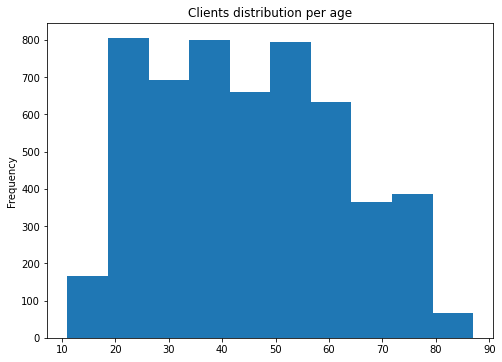

In [16]:
#plotting customers distribution by age
clients_df ['age'].plot (kind = 'hist',
                    title = 'Clients distribution per age',
                   # width = 0.75,
                    figsize = (8, 5.8)
                    )

In [17]:
#Clients gender visualization

target1 = clients_df [clients_df ['gender'] == 1.0].shape [0]
target0 = clients_df [clients_df ['gender'] == 0.0].shape [0]

trace0 = go.Bar (
    x = ['Men', 'Women'],
    y = [target1/ (target1 + target0) *100, target0/ (target1 + target0) *100], 
    marker = dict (color=['rgba(34, 167, 240, 1)', 'rgba(222,45,38,0.8)']
                  ),
) 
data = [trace0]
layout = go.Layout (title = 'Gender proportion (%)', autosize= False, width= 500, height= 500,
                    )
fig = go.Figure (data=data, layout = layout)
#plotly.offline.iplot()
py.iplot (fig, filename = 'test')

In [18]:
print ('Percentage of men: '+ str (target1/clients_df.shape [0]*100) +'%' + ' percentage of women: ' + str (target0/clients_df.shape [0]*100) + '%')

Percentage of men: 50.73570497299311% percentage of women: 49.264295027006895%


In [19]:
#enriching customer info with habitation info   
clients_dist_df = clients_df
clients_dist2_df = clients_dist_df.merge (district_df, left_on = 'district_id', right_on = 'A1', 
                                           how = 'left') 
display (clients_df.head (n=3))
display (clients_dist2_df.head (n=3))      

client_id  birth_number  district_id birth_date  gender  age
0          1        706213           18 1970-12-13     0.0   28
1          2        450204            1 1945-02-04     1.0   53
2          3        406009            1 1940-10-09     0.0   58

client_id  birth_number  district_id birth_date  gender  age  A1  \
0          1        706213           18 1970-12-13     0.0   28  18   
1          2        450204            1 1945-02-04     1.0   53   1   
2          3        406009            1 1940-10-09     0.0   58   1   

            A2             A3       A4  ...    A7  A8  A9    A10    A11   A12  \
0        Pisek  south Bohemia    70699  ...     2   1   4   65.3   8968  2.83   
1  Hl.m. Praha         Prague  1204953  ...     0   1   1  100.0  12541  0.29   
2  Hl.m. Praha         Prague  1204953  ...     0   1   1  100.0  12541  0.29   

    A13  A14    A15    A16  
0  3.35  131   1740   1910  
1  0.43  167  85677  99107  
2  0.43  167  85677  99107  

[3 rows x 22 columns]

In [20]:
#grouping by district ("A2") and population of the district ('A4'), then counting number of customers 
district_clients_df = pd.DataFrame (clients_dist2_df.groupby (['A2', 'A4', 'A11'], axis = 0) ['A2'].count ())
district_clients_df.columns = ['count']

#making columns out of multi-index of A3 and type_x so to make it easier to operate with values
district_clients_df.reset_index (inplace = True)

#calculating portion of clients in the population of a district
district_clients_df ['portion'] = district_clients_df ['count'] / district_clients_df ['A4'] * 100

display (district_clients_df .head (n=5))
district_clients_df ['count'].sum ()

A2      A4   A11  count   portion
0       Benesov   88884  8507     46  0.051753
1        Beroun   75232  8980     63  0.083741
2       Blansko  107911  8240     57  0.052821
3       Breclav  124605  8772     54  0.043337
4  Brno - mesto  387570  9897    155  0.039993

5369

In [21]:
#average value of average salaries within districts
district_df ['A11'].mean ()

9031.675324675325

In [22]:
#average value of Relative number of clients comparing to district population
district_clients_df ['portion'].mean ()

0.057953262626622946

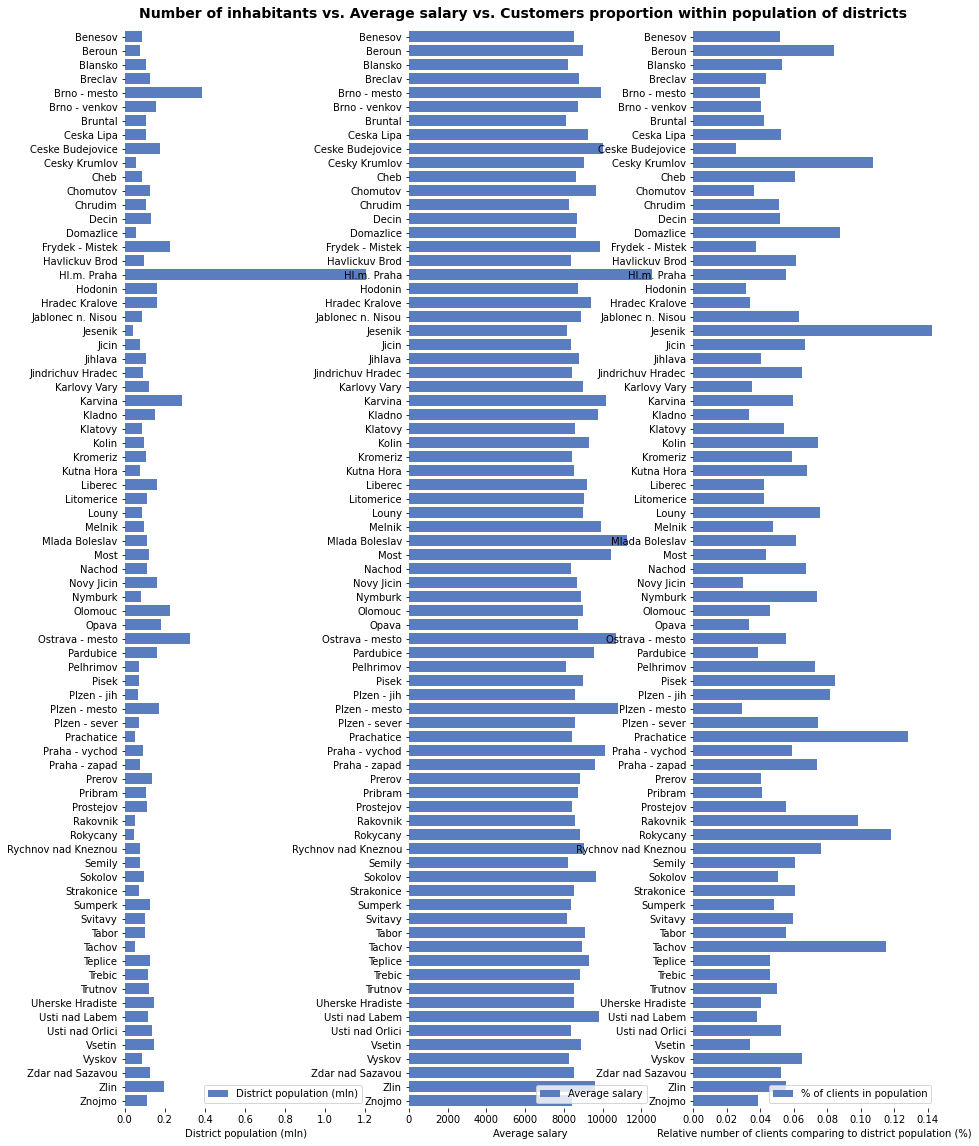

In [23]:
#plotting Number of inhabitants vs. Average salary vs. Customers proportion within population of districts
district_clients_df2 = district_clients_df.copy ()
district_clients_df2['A4'] = district_clients_df2['A4'] / 1000000 

## Initialize the matplotlib figure:
fig2, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,16), sharey=False)
fig2.tight_layout()  #When working with 'tight_layout', the subplot must be adjusted [https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot]
fig2.subplots_adjust(top=0.96)  #Adjusting the space for the superior title

## Plot the District population
sns.set_color_codes("muted")
sns.barplot(x="A4", y="A2", data=district_clients_df2, label = 'District population (mln)',color="b", ax=ax1)
## Add a legend and informative axis label
ax1.legend(ncol=2, loc="lower right", frameon=True)
ax1.set(xlim=(0, 1.21), ylabel="", xlabel="District population (mln)")
sns.despine(left=True, bottom=True,ax=ax1)

## Plot the Average salary
sns.set_color_codes("muted")
sns.barplot(x="A11", y="A2", data=district_clients_df, label="Average salary", color="b", ax=ax2)
## Add a legend and informative axis label
ax2.legend(ncol=2, loc="lower right", frameon=True)
ax2.set(xlim=(0, 12541), ylabel="", xlabel="Average salary")  #The xlim value comes from the maximum value in the dataset.
sns.despine(left=True, bottom=True, ax=ax2)

sns.set_color_codes("muted")
sns.barplot(x="portion", y="A2", data=district_clients_df, label="% of clients in population", color="b", ax=ax3)
## Add a legend and informative axis label
ax3.legend(ncol=2, loc="lower right", frameon=True)
ax3.set(xlim=(0, 0.145), ylabel="", xlabel="Relative number of clients comparing to district population (%)")  #The xlim value comes from the maximum value in the dataset.
sns.despine(left=True, bottom=True, ax=ax3)

plt.suptitle('Number of inhabitants vs. Average salary vs. Customers proportion within population of districts', fontsize=14, fontweight='bold')
plt.show()

<AxesSubplot:title={'center':'Clients distribution per districts'}>

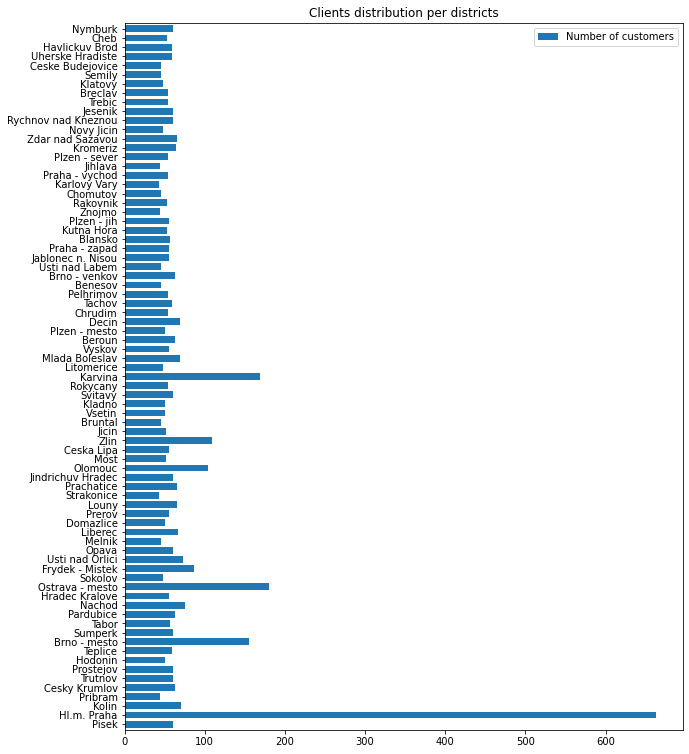

In [24]:
#Plotting clients presence in different districts
reg_count = Counter (clients_dist2_df ['A2'])
region_counts = pd.DataFrame.from_dict (reg_count, orient = 'index')
region_counts.columns = ['Number of customers']
region_counts2 = region_counts# / (region_counts ['Percentage_ratio'].sum ()) * 100

region_counts2.plot (kind = 'barh',
                    title = 'Clients distribution per districts',
                    width = 0.75,
                    figsize = (10, 13)
                    )

In [85]:
clients_dist2_df.head(3)

client_id  birth_number  district_id birth_date  gender  age  A1  \
0          1        706213           18 1970-12-13     0.0   28  18   
1          2        450204            1 1945-02-04     1.0   53   1   
2          3        406009            1 1940-10-09     0.0   58   1   

            A2             A3       A4  ...    A7  A8  A9    A10    A11   A12  \
0        Pisek  south Bohemia    70699  ...     2   1   4   65.3   8968  2.83   
1  Hl.m. Praha         Prague  1204953  ...     0   1   1  100.0  12541  0.29   
2  Hl.m. Praha         Prague  1204953  ...     0   1   1  100.0  12541  0.29   

    A13  A14    A15    A16  
0  3.35  131   1740   1910  
1  0.43  167  85677  99107  
2  0.43  167  85677  99107  

[3 rows x 22 columns]

<AxesSubplot:title={'center':'Clients distribution per regions'}>

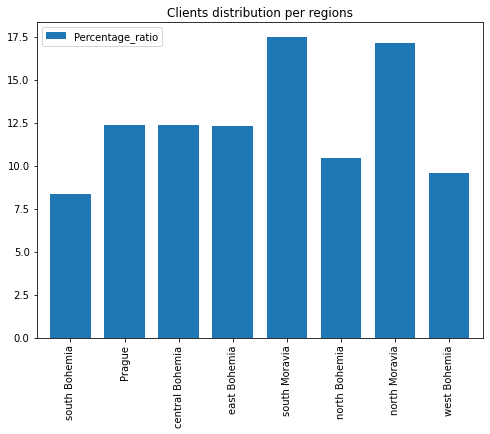

In [26]:
#Plotting clients presence in different major regions

reg_count = Counter (clients_dist2_df ['A3'])
region_counts = pd.DataFrame.from_dict (reg_count, orient = 'index')
region_counts.columns = ['Percentage_ratio']
region_counts2 = region_counts / (region_counts ['Percentage_ratio'].sum ()) * 100
region_counts2.plot (kind = 'bar',
                    title = 'Clients distribution per regions',
                    width = 0.75,
                    figsize = (8, 5.8))

In [27]:
#Average salaries in the regions
region_salary_df = pd.DataFrame (district_df.groupby (['A3'], axis = 0) ['A11'].mean ()).sort_values ('A11')
display (region_salary_df.head (n=10))

A11
A3                           
east Bohemia      8611.181818
south Moravia     8728.500000
south Bohemia     8831.500000
west Bohemia      9015.400000
north Moravia     9049.181818
north Bohemia     9334.200000
central Bohemia   9357.250000
Prague           12541.000000

In [28]:
#Plotting average salary per regions
trace0 = go.Bar (
    x = region_salary_df.index,
    y = region_salary_df ['A11'], 
) 
data = [trace0]
layout = go.Layout (title = 'Average salary per region', autosize= False, width= 600, height= 400,
                    )
fig = go.Figure (data=data, layout = layout)
py.iplot (fig, filename = 'Salaries')

### Question métier#1 conclusion: 

- Les hommes et les femmes sont presque également représentés parmi les clients de la banque, 50,74% pour les hommes et 49,26% pour les femmes.
- La majorité des clients sont âgés de 20 à 60 ans. 
- La plupart des clients vivent en Moravie du Sud et du Nord, alors que le Sud et l'Ouest de Bohemia sont les régions les moins représentées. Le salaire moyen est presque uniformément réparti entre les régions, à l'exception de Prague (capitale du pays), où le salaire moyen est nettement plus élevé. Apparemment, l'invasion du marché bancaire de Prague devrait être renforcée.  
- Les districts suivants sont les plus attractifs : Hl. m. Praha, Brno-mesto, Karvina, Ostrava-mesto, Praha-Vychod, Frydek-Mistek (assez proche des critères) pour une future croissance de la présence sur le marché. 

### Question métier#2 - Types de carte bleue

- Vue d'ensemble de la proportion des cartes émis.
- Répartition des cartes entre les différentes régions de la République tchèque. Y a-t-il des régions où certains types de cartes sont plus populaires que d'autres ?
- Aperçu des tendances en matière d'émission de cartes de 1993 à 1998.

Counter({'classic': 659, 'junior': 145, 'gold': 88})

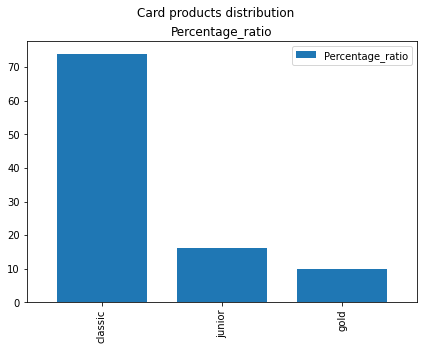

In [29]:
# Card products popularity 

product_count = Counter (cards_df ['type'])
product_counts = pd.DataFrame.from_dict (product_count, orient = 'index')
product_counts.columns = ['Percentage_ratio']
product_counts = product_counts / (product_counts ['Percentage_ratio'].sum ()) * 100
product_counts.plot (kind = 'bar',
                title = 'Card products distribution',
                width = 0.75,
                figsize = (7, 4.8),
                subplots = True
                    )
display (product_count)

In [30]:
#merging cards_df and corresponding dispos_df so to find client_id and then from client_id to find corresponding region data

cards_disp_df = cards_df
cards_disp2_df = cards_disp_df.merge (dispos_df, left_on = 'disp_id', right_on = 'disp_id', 
                                           how = 'left') 
display (cards_df.head (n=3))
display (cards_disp2_df.head (n=3))     
print ("Verifying shape. Before: " + str (cards_df.shape)+ " After: " + str (cards_disp2_df.shape))

card_id  disp_id     type           issued
0     1005     9285  classic  931107 00:00:00
1      104      588  classic  940119 00:00:00
2      747     4915  classic  940205 00:00:00

card_id  disp_id   type_x           issued  client_id  account_id type_y
0     1005     9285  classic  931107 00:00:00       9593        7753  OWNER
1      104      588  classic  940119 00:00:00        588         489  OWNER
2      747     4915  classic  940205 00:00:00       4915        4078  OWNER

Verifying shape. Before: (892, 4) After: (892, 7)


In [31]:
#merging cards_disp2_df with clients_dist2_df. as a result I will have a df with card products and corresponding regions info
#in the same DF

cards_disp3_df = cards_disp2_df
cards_disp_reg_df = cards_disp3_df.merge (clients_dist2_df, left_on = 'client_id', right_on = 'client_id', 
                                           how = 'left') 
display (cards_disp2_df.head (n=3))
display (cards_disp_reg_df.head (n=3))     
print ("Verifying shape. Before: " + str (cards_disp2_df.shape)+ " After: " + str (cards_disp_reg_df.shape))

card_id  disp_id   type_x           issued  client_id  account_id type_y
0     1005     9285  classic  931107 00:00:00       9593        7753  OWNER
1      104      588  classic  940119 00:00:00        588         489  OWNER
2      747     4915  classic  940205 00:00:00       4915        4078  OWNER

card_id  disp_id   type_x           issued  client_id  account_id type_y  \
0     1005     9285  classic  931107 00:00:00       9593        7753  OWNER   
1      104      588  classic  940119 00:00:00        588         489  OWNER   
2      747     4915  classic  940205 00:00:00       4915        4078  OWNER   

   birth_number  district_id birth_date  ...    A7  A8  A9    A10    A11  \
0        685128           74 1968-01-28  ...     0   1   1  100.0  10673   
1        606020           61 1960-10-20  ...     5   1   6   53.8   8814   
2        630719           40 1963-07-19  ...     6   3   8   85.3   9317   

    A12   A13  A14    A15    A16  
0  4.75  5.44  100  18782  18347  
1  4.76  5.74  107   2112   2059  
2  6.49  7.07   97   6949   6872  

[3 rows x 28 columns]

Verifying shape. Before: (892, 7) After: (892, 28)


In [32]:
#preparing dataset for plotting of number of products per regions

#grouping by region ("A3") and card product ('type_x'), then counting number of cards 
region_product_df = pd.DataFrame (cards_disp_reg_df.groupby (['A3', 'type_x'], axis = 0) ['type_x'].count ())
region_product_df.columns = ['count']

#making columns out of multi-index of A3 and type_x so to make it easier to operate with values
region_product_df.reset_index (level= ['type_x', 'A3'], inplace = True)
display (region_product_df .head (n=5))

A3   type_x  count
0           Prague  classic     96
1           Prague     gold     12
2           Prague   junior     22
3  central Bohemia  classic     88
4  central Bohemia     gold      9

In [33]:
regions_duplicate = region_product_df.copy () #should be used as copy () otherwise in the loop both df updated
for ids, item in enumerate (region_product_df ['A3']):
    count_sum = regions_duplicate.loc [ids, 'count']
    div_sum = regions_duplicate [regions_duplicate ['A3'] == item] ['count']. sum ()
    region_product_df.loc [ids, 'count'] = round (count_sum / (div_sum) *100)
display (region_product_df .head (n=5))

A3   type_x  count
0           Prague  classic     74
1           Prague     gold      9
2           Prague   junior     17
3  central Bohemia  classic     73
4  central Bohemia     gold      8

In [34]:
#plotting percentage of card products per regions 
x = list (region_product_df ['A3'].unique()) #region names
y =  list (region_product_df [region_product_df ['type_x'] == 'junior'] ['count']) #junior
y2 = list (region_product_df [region_product_df ['type_x'] == 'classic'] ['count']) #classic
y3 = list (region_product_df [region_product_df ['type_x'] == 'gold'] ['count']) #gold
junior = go.Bar(
    x=x,
    y=y,
    text= y,
    name = 'Junior',
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
classic = go.Bar(
    x=x,
    y=y2,
    text=y2,
    name = 'Classic',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
gold = go.Bar(
    x=x,
    y=y3,
    text=y3,
    name = 'Gold',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
data = [junior, classic, gold]
py.iplot(data, filename='grouped-bar-direct-labels')

In [35]:
#preparing dataset for plotting trends of cards issuance per years

#adding a column that will reflect specific year when a card was issued
cards_disp2_df ['issue_year'] = cards_disp2_df ['issued']

cards_disp2_df ['issue_year'] = cards_disp2_df ['issue_year'].apply (date_parsing)
cards_disp2_df.head (n=3)

card_id  disp_id   type_x           issued  client_id  account_id type_y  \
0     1005     9285  classic  931107 00:00:00       9593        7753  OWNER   
1      104      588  classic  940119 00:00:00        588         489  OWNER   
2      747     4915  classic  940205 00:00:00       4915        4078  OWNER   

   issue_year  
0        1993  
1        1994  
2        1994

In [36]:
#grouping by issue_year and card product ('type_x'), then counting number of cards 
year_product_df = pd.DataFrame (cards_disp2_df.groupby (['issue_year', 'type_x'], axis = 0) ['type_x'].count ())

#naming column as 'count' 
year_product_df.columns = ['count']

#making columns out of multi-index of A3 and type_x so to make it easier to operate with values
year_product_df.reset_index (level= ['type_x', 'issue_year'], inplace = True)
display (year_product_df .head (n=5))

issue_year   type_x  count
0        1993  classic      1
1        1994  classic     17
2        1994   junior      4
3        1995  classic     42
4        1995     gold      4

In [37]:
#no values for junior and gold products in 1993 and no values for gold cards in 1994
#adding them as zeroes

list_of_zer = [pd.Series ([1993, 'junior', 0], index = year_product_df.columns),
               pd.Series ([1993, 'gold', 0], index = year_product_df.columns),
               pd.Series ([1994, 'gold', 0], index = year_product_df.columns),
                ]
year_product_df = year_product_df.append (list_of_zer, ignore_index = True)
year_product_df.sort_values (['issue_year', 'type_x'], inplace= True)
year_product_df.reset_index (inplace = True, drop = True) #making index start from 0 again
display (year_product_df .head (n=5))

issue_year   type_x  count
0        1993  classic      1
1        1993     gold      0
2        1993   junior      0
3        1994  classic     17
4        1994     gold      0

In [38]:
#plotting number of card products per years 
x = list (year_product_df ['issue_year'].unique()) #years 
y =  list (year_product_df [year_product_df ['type_x'] == 'junior'] ['count']) #junior
y2 = list (year_product_df [year_product_df ['type_x'] == 'classic'] ['count']) #classic
y3 = list (year_product_df [year_product_df ['type_x'] == 'gold'] ['count']) #gold

junior = go.Bar(
    x=x,
    y=y,
    text= y,
    name = 'Junior',
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
classic = go.Bar(
    x=x,
    y=y2,
    text=y2,
    name = 'Classic',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
gold = go.Bar(
    x=x,
    y=y3,
    text=y3,
    name = 'Gold',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
data = [junior, classic, gold]
py.iplot(data, filename='grouped-bar-direct-labels')

In [39]:
#making a new dataset that will contain percentage of each card product per year 

year_duplicate = year_product_df.copy () #should be used as copy () otherwise in the loop both df updated
for ids, item in enumerate (year_product_df ['issue_year']):
    count_sum = year_duplicate.loc [ids, 'count']
    div_sum = year_duplicate [year_duplicate ['issue_year'] == item] ['count']. sum ()
    year_product_df.loc [ids, 'count'] = round (count_sum / (div_sum) *100)
      
display (year_product_df .head (n=5))

issue_year   type_x  count
0        1993  classic    100
1        1993     gold      0
2        1993   junior      0
3        1994  classic     81
4        1994     gold      0

In [40]:
#plotting percentafe of card products per years 
x = list (year_product_df ['issue_year'].unique()) #years 
y =  list (year_product_df [year_product_df ['type_x'] == 'junior'] ['count']) #junior
y2 = list (year_product_df [year_product_df ['type_x'] == 'classic'] ['count']) #classic
y3 = list (year_product_df [year_product_df ['type_x'] == 'gold'] ['count']) #gold

junior = go.Bar(
    x=x,
    y=y,
    text= y,
    name = 'Junior',
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
classic = go.Bar(
    x=x,
    y=y2,
    text=y2,
    name = 'Classic',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
gold = go.Bar(
    x=x,
    y=y3,
    text=y3,
    name = 'Gold',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
data = [junior, classic, gold]
py.iplot(data, filename='grouped-bar-direct-labels')

### Question métier #2 conclusion: 

- Vue d'ensemble de la proportion de catégorie de cartes émise : 74% des cartes émises sont des cartes classiques, 16% des cartes junior et 10% des cartes gold.  
- Répartition des produits de cartes entre les différentes régions de la République tchèque. Y a-t-il des régions où certains produits de cartes sont plus populaires que d'autres ?  Dans toutes les régions, la majorité des cartes sont "classiques" - plus de 70%, les cartes junior l'emportent sur les cartes gold dans toutes les régions, sauf en Bohemia du Nord.  
- Aperçu des tendances en matière d'émission de cartes de 1993 à 1998. Le nombre de cartes émises augmente d'année en année. Les cartes classiques restent les plus populaires auprès des clients. Les cartes junior occupent la deuxième place, les cartes gold la troisième, à l'exception de l'année 1997 où le nombre de cartes émises par les deux produits est égal.  


### Question métier #3: transactions 

- Distribution des types de transactions dans l'ensemble de données  
- Tendances et modèles possibles dans la distribution des transactions au cours de la période donnée (1993-1998). Y a-t-il un type de transaction qui était moins populaire et dont le nombre a augmenté au fil du temps ?  
- Examen plus approfondi des transferts de fonds depuis et vers d'autres banques. Le solde global est-il positif ? Y a-t-il des tendances avec le solde dans la période donnée ? 


In [41]:
#take a look to the subset where operation values are missing

trans_opermis_df = trans_df [trans_df ['operation'].isnull ()] [trans_df.columns]
trans_opermis_df.head (n=3)

trans_id  account_id       date    type operation  amount  balance  \
137   3591421        1844 1993-01-31  PRIJEM       NaN    12.6   3754.6   
138   3617490        2632 1993-01-31  PRIJEM       NaN    47.5  15411.5   
139   3579543        1493 1993-01-31  PRIJEM       NaN    13.3   5222.3   

    k_symbol bank  account  
137     UROK  NaN      NaN  
138     UROK  NaN      NaN  
139     UROK  NaN      NaN

In [42]:
#interpretation why it is missing

trans_opermis_df.groupby ('type', axis =0).count ()

trans_id  account_id    date  operation  amount  balance  k_symbol  \
type                                                                         
PRIJEM    183114      183114  183114          0  183114   183114    183114   

        bank  account  
type                   
PRIJEM     0        0

In [43]:
trans_opermis_df.groupby ('k_symbol', axis =0).count ()

trans_id  account_id    date    type  operation  amount  balance  \
k_symbol                                                                     
UROK        183114      183114  183114  183114          0  183114   183114   

          bank  account  
k_symbol                 
UROK         0        0

Il s'avère que la seule valeur possible dans k_symbol pour le sous-ensemble est "UROK" qui signifie "intérêts créditeurs". Nous pouvons en conclure que les valeurs d'opération sont manquantes car il s'agit de transactions "intérêt créditeur", elles ne peuvent pas être remplies par un autre type d'opération comme un retrait, un versement ou autre. 
Nous pouvons remplacer les valeurs manquantes dans "opération" par la nouvelle valeur "intérêt_crédit".

In [44]:
#substituting missing values in "operation"
trans_df ['operation'].fillna ('INTEREST_CREDIT', inplace = True)

#filling all missing values as np.NaN
trans_df.fillna (np.NaN, inplace = True)

trans_df.isnull ().sum ()

trans_id           0
account_id         0
date               0
type               0
operation          0
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64

Percentage_ratio
Credit in cash                       14.838591
Collection from another bank          6.174833
Withdrawal in cash                   41.172940
Interest credit                      17.335088
Remittance to another bank           19.717794
Withdrawal from credit card           0.760754

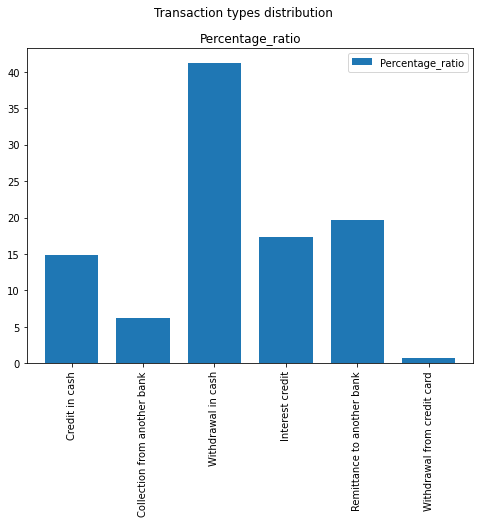

In [45]:
#transactions popularity for the whole reported period 

trans_count = Counter (trans_df ['operation'])

trans_counts = pd.DataFrame.from_dict (trans_count, orient = 'index')
trans_counts.columns = ['Percentage_ratio']
trans_counts = trans_counts / (trans_counts ['Percentage_ratio'].sum ()) * 100

#renaming indices 
trans_counts.rename (index = {'VKLAD':'Credit in cash', 'PREVOD Z UCTU':'Collection from another bank', 'VYBER':'Withdrawal in cash',
                             'INTEREST_CREDIT':'Interest credit', 'PREVOD NA UCET':'Remittance to another bank', 
                             'VYBER KARTOU':'Withdrawal from credit card'}, inplace = True)#, , , 
                            #'Remittance to another bank', ], inplace = True)

trans_counts.plot (kind = 'bar',
                    title = 'Transaction types distribution',
                    width = 0.75,
                    figsize = (8, 5.8),
                    subplots = True, 
                    )
trans_counts #pd.DataFrame (list(trans_count.items ())) #/trans_df.shape [0]*100

In [46]:
#adding a column indicating a year when a transaction was performed 
trans_df ['tran_year'] = trans_df ['date']
trans_df ['tran_year'] = trans_df ['tran_year'].apply (year_extract)
    
trans_df.head (n=3)

trans_id  account_id       date    type operation  amount  balance  \
0    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1    171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   

  k_symbol bank  account  tran_year  
0      NaN  NaN      NaN       1993  
1      NaN  NaN      NaN       1993  
2      NaN  NaN      NaN       1993

In [47]:
#grouping by tran_year and operation, then counting number of transactions  
year_trantype_df = pd.DataFrame (trans_df.groupby (['tran_year', 'operation'], axis = 0) ['operation'].count ())

#naming column as 'count' 
year_trantype_df.columns = ['count']

#making columns out of multi-index of tran_year and operation so to make it easier to operate with values
year_trantype_df.reset_index (level= ['operation', 'tran_year'], inplace = True)

display (year_trantype_df .head (n=3))

tran_year        operation  count
0       1993  INTEREST_CREDIT   6065
1       1993   PREVOD NA UCET   3231
2       1993    PREVOD Z UCTU   2462

In [48]:
#no values for VYBER KARTOU in 1993 
#adding as zero

list_of_zer1 = [pd.Series ([1993, 'VYBER KARTOU', 0], index = year_trantype_df.columns)]
year_trantype_df = year_trantype_df.append (list_of_zer1, ignore_index = True)

year_trantype_df.sort_values (['tran_year', 'operation'], inplace= True)
year_trantype_df.reset_index (inplace = True, drop = True) #making index start from 0 again
display (year_trantype_df .head (n=6))

tran_year        operation  count
0       1993  INTEREST_CREDIT   6065
1       1993   PREVOD NA UCET   3231
2       1993    PREVOD Z UCTU   2462
3       1993            VKLAD   6685
4       1993            VYBER   9762
5       1993     VYBER KARTOU      0

In [49]:
#plotting number of transactions per year 

x = list (year_trantype_df ['tran_year'].unique()) #years 
y =  list (year_trantype_df [year_trantype_df ['operation'] == 'INTEREST_CREDIT'] ['count']) 
y2 = list (year_trantype_df [year_trantype_df ['operation'] == 'PREVOD NA UCET'] ['count']) 
y3 = list (year_trantype_df [year_trantype_df ['operation'] == 'PREVOD Z UCTU'] ['count']) 
y4 = list (year_trantype_df [year_trantype_df ['operation'] == 'VKLAD'] ['count']) 
y5 = list (year_trantype_df [year_trantype_df ['operation'] == 'VYBER'] ['count']) 
y6 = list (year_trantype_df [year_trantype_df ['operation'] == 'VYBER KARTOU'] ['count']) 

bar1 = go.Bar(
    x=x,
    y=y,
    text= y,
    name = 'Interest credit',
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

bar2 = go.Bar(
    x=x,
    y=y2,
    text=y2,
    name = 'Remittance to another bank',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

bar3 = go.Bar(
    x=x,
    y=y3,
    text=y3,
    name = 'Collection from another bank',
    textposition = 'auto',
    marker=dict(
        color='rgb(128,0,128)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

bar4 = go.Bar(
    x=x,
    y=y4,
    text=y4,
    name = 'Credit in cash',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,139,139)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

bar5 = go.Bar(
    x=x,
    y=y5,
    text=y5,
    name = 'Withdrawal in cash',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

bar6 = go.Bar(
    x=x,
    y=y6,
    text=y6,
    name = 'Withdrawal from credit card',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,0,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

data = [bar1, bar2, bar3, bar4, bar5, bar6]

py.iplot(data, filename='grouped-bar-direct-labels')

In [50]:
#investigating transactions marked as "collection from another bank" 

trans_col_df = trans_df [trans_df ['operation'] == 'PREVOD Z UCTU']

#unique values in the column k_symbol which will describe possible reason for collection
trans_col_df ['k_symbol'].unique ()

array(['DUCHOD', nan], dtype=object)

In [51]:
#checking proportion of each possible value: DUCHOD ( old-age pension) and NaNs
pd.DataFrame(Counter (trans_col_df ['k_symbol']), index = [0]).transpose () / trans_col_df.shape [0] * 100

0
DUCHOD  46.512127
NaN     53.487873

On peut conclure que 46.5% des transactions "collection from another bank" sont des pensions de retraite et 53.5% des transactions ne sont pas specifiés.   


In [52]:
trans_col_df [trans_col_df ['k_symbol'] == 'DUCHOD'] ['amount'].sum ()

167472118.0

In [53]:
trans_col_df [trans_col_df ['k_symbol'] != 'DUCHOD'] ['amount'].sum ()

614007835.0

In [54]:
#investigating transactions marked as "remittance to another bank"
trans_rem_df = trans_df [trans_df ['operation'] == 'PREVOD NA UCET']

#unique values in the column k_symbol which will describe possible reason for collection
trans_rem_df ['k_symbol'].unique ()

array(['SIPO', ' ', 'POJISTNE', nan, 'UVER'], dtype=object)

In [55]:
#filling spaces in k_symbol with NaN
trans_rem_df = trans_rem_df.replace(r'^\s*$', np.nan, regex=True)

In [56]:
#verifying result 
trans_rem_df ['k_symbol'].unique ()

array(['SIPO', nan, 'POJISTNE', 'UVER'], dtype=object)

In [57]:
#checking proportion of each possible value for remittance transactions
pd.DataFrame(Counter (trans_rem_df ['k_symbol']), index = [0]).transpose () / trans_rem_df.shape [0] * 100

0
SIPO      55.335289
NaN       29.273633
POJISTNE   8.871103
UVER       6.519975

From the above we see that majority (55.3%) of remittance transactions related to household payments, on the second place (29.3%) payment reason unknown, on the third (8.9%) - insurance payments, on the last place (6.5%) - loan payments. 

In [58]:
#verifying positive/negative balance between collection from another banks and remittance to another banks
trans_colrem_df = trans_col_df.append (trans_rem_df)

#overall balance of incoming (PREVOD Z UCTU) and outgoing (PREVOD NA UCET)
display (pd.DataFrame (trans_colrem_df.groupby (['operation']).sum () ['amount'].sort_values ()))

#proportion 
display (pd.DataFrame (trans_colrem_df.groupby (['operation']).sum () ['amount'].sort_values ())/trans_colrem_df ['amount'].sum () *100)


amount
operation                  
PREVOD NA UCET  672637786.3
PREVOD Z UCTU   781479953.0

amount
operation               
PREVOD NA UCET  46.25745
PREVOD Z UCTU   53.74255

In [59]:
#mean of remittance and collection 
display (pd.DataFrame (trans_colrem_df.groupby (['operation']).mean () ['amount'].sort_values ()))

amount
operation                   
PREVOD NA UCET   3229.441607
PREVOD Z UCTU   11981.111106

De 1993 à 1998, le solde global est positif : le montant reçu est plus important de 7,5 % par rapport aux sorties.

In [60]:
#now let's take a look if there is any trend from 1993 to 1998 in the amounts for remittance and collection
year_transfer_df = pd.DataFrame (trans_colrem_df.groupby (['operation','tran_year'], axis = 0) ['amount'] .sum ().sort_values ())

#naming column as 'sum' 
year_transfer_df.columns = ['sum']

#making columns out of multi-index so to make it easier to operate with values
year_transfer_df.reset_index (inplace = True)

#renaming values in operation so to have better visibility
dict11 =  {'PREVOD NA UCET':'Remittance to another bank', 
      'PREVOD Z UCTU':'Collection from another bank'
     }
year_transfer_df.operation = year_transfer_df.operation.replace (dict11)

display (year_transfer_df .head (n=30))


operation  tran_year          sum
0     Remittance to another bank       1993   10159410.7
1   Collection from another bank       1993   29809129.0
2     Remittance to another bank       1994   53841549.1
3   Collection from another bank       1994   68925764.0
4     Remittance to another bank       1995   81845324.4
5   Collection from another bank       1995   99242619.0
6     Remittance to another bank       1996  119563522.2
7   Collection from another bank       1996  146015899.0
8     Remittance to another bank       1997  182443823.2
9   Collection from another bank       1997  207339926.0
10    Remittance to another bank       1998  224784156.7
11  Collection from another bank       1998  230146616.0

In [61]:
#plotting sum of remittance and collection per years 
x = list (year_transfer_df ['tran_year'].unique()) #years 
y =  list (year_transfer_df [year_transfer_df ['operation'] == 'Remittance to another bank'] ['sum']) 
y2 = list (year_transfer_df [year_transfer_df ['operation'] == 'Collection from another bank'] ['sum']) 

bar2 = go.Bar(
    x=x,
    y=y,
    text=y,
    name = 'Remittance to another bank',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
bar5 = go.Bar(
    x=x,
    y=y2,
    text=y2,
    name = 'Collection from another bank',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)
data = [bar2, bar5]
py.iplot(data, filename='grouped-bar-direct-labels')

In [62]:
#a dataframe for plotting remittance and colletion by months distribution
trans_remcol_df = trans_colrem_df.copy ()

#columns with amounts that affects balance positively - collection from another banks 
trans_remcol_df = trans_remcol_df.assign (pos_sum = np.nan)

#columns with amounts that affects balance negatively - remittance to another banks
trans_remcol_df = trans_remcol_df.assign (neg_sum = np.nan)

#filling columns pos_sum and neg_sum based on operation type. pos_sum stands for inflows
trans_remcol_df.pos_sum = trans_remcol_df.amount.where (trans_remcol_df.operation == 'PREVOD Z UCTU', trans_remcol_df.pos_sum)

#neg_sum stands for outflows
trans_remcol_df.neg_sum = trans_remcol_df.amount.where (trans_remcol_df.operation == 'PREVOD NA UCET', trans_remcol_df.neg_sum )

display (trans_remcol_df.head (n=3))
trans_remcol_df [trans_remcol_df ['operation'] == 'PREVOD Z UCTU'].tail (n=3)


trans_id  account_id       date    type      operation  amount  balance  \
15    637742        2177 1993-01-05  PRIJEM  PREVOD Z UCTU  5123.0   5923.0   
17    232961         793 1993-01-05  PRIJEM  PREVOD Z UCTU  3401.0   4201.0   
21    542216        1844 1993-01-07  PRIJEM  PREVOD Z UCTU  3242.0   3742.0   

   k_symbol bank     account  tran_year  pos_sum  neg_sum  
15   DUCHOD   YZ  62457513.0       1993   5123.0      NaN  
17      NaN   IJ   6149286.0       1993   3401.0      NaN  
21      NaN   ST  42988401.0       1993   3242.0      NaN

trans_id  account_id       date    type      operation   amount  \
1047122    546460        1860 1998-12-14  PRIJEM  PREVOD Z UCTU   3255.0   
1047127    605757        2062 1998-12-14  PRIJEM  PREVOD Z UCTU  64642.0   
1047137    519257        1773 1998-12-14  PRIJEM  PREVOD Z UCTU   4316.0   

         balance k_symbol bank     account  tran_year  pos_sum  neg_sum  
1047122  20916.3      NaN   MN  61854898.0       1998   3255.0      NaN  
1047127  97552.6      NaN   EF  10179949.0       1998  64642.0      NaN  
1047137  17215.9   DUCHOD   CD  77385341.0       1998   4316.0      NaN

In [63]:
#we need a pandas.DateTimeIndex for resampling
trans_remcol_df.set_index (trans_remcol_df ['date'], inplace = True)
trans_remcol_df.head (n=3)

trans_id  account_id       date    type      operation  amount  \
date                                                                         
1993-01-05    637742        2177 1993-01-05  PRIJEM  PREVOD Z UCTU  5123.0   
1993-01-05    232961         793 1993-01-05  PRIJEM  PREVOD Z UCTU  3401.0   
1993-01-07    542216        1844 1993-01-07  PRIJEM  PREVOD Z UCTU  3242.0   

            balance k_symbol bank     account  tran_year  pos_sum  neg_sum  
date                                                                        
1993-01-05   5923.0   DUCHOD   YZ  62457513.0       1993   5123.0      NaN  
1993-01-05   4201.0      NaN   IJ   6149286.0       1993   3401.0      NaN  
1993-01-07   3742.0      NaN   ST  42988401.0       1993   3242.0      NaN

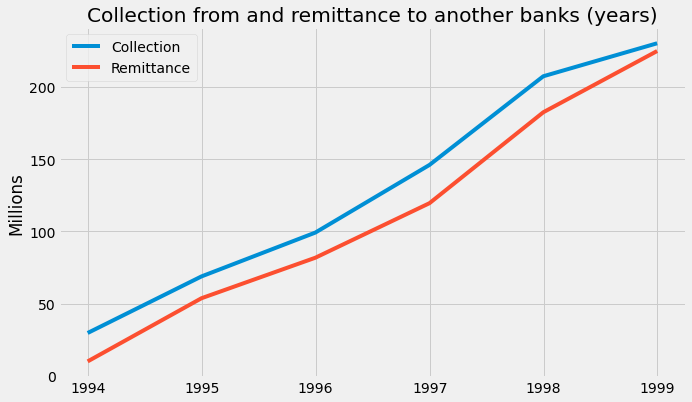

In [64]:
#plotting results with aggregation on the level of years
inflows = trans_remcol_df['pos_sum'].resample('A').sum ()
outflows = trans_remcol_df['neg_sum'].resample('A').sum ()

plt.style.use('fivethirtyeight')
x = outflows.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = list (inflows / 1000000) 
y2 = list (outflows / 1000000)

ax.set_ylabel('Millions')
ax.plot(x, y1, label = 'Collection')
ax.plot(x, y2, label = 'Remittance' )#, figsize = (8,8))
ax.set_title("Collection from and remittance to another banks (years)")
plt.legend (loc = 'best')
plt.show()

In [65]:
#complementing trans_df with account data and district data
trans_acc_df = trans_df.copy ()
trans_acc_df = trans_acc_df.merge (accounts_df, left_on = 'account_id', right_on = 'account_id', 
                                           how = 'left') 
trans_acc_dist_df = trans_acc_df.merge (district_df, left_on = 'district_id', right_on = 'A1', 
                                           how = 'left')
display (trans_df.head (n=3))
display (trans_acc_df.head (n=3)) 
display (trans_acc_dist_df.head (n=3))

trans_id  account_id       date    type operation  amount  balance  \
0    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1    171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   

  k_symbol bank  account  tran_year  
0      NaN  NaN      NaN       1993  
1      NaN  NaN      NaN       1993  
2      NaN  NaN      NaN       1993

trans_id  account_id     date_x    type operation  amount  balance  \
0    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1    171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   

  k_symbol bank  account  tran_year  district_id         frequency     date_y  
0      NaN  NaN      NaN       1993           16  POPLATEK MESICNE 1993-01-01  
1      NaN  NaN      NaN       1993           55  POPLATEK MESICNE 1993-01-01  
2      NaN  NaN      NaN       1993           55  POPLATEK MESICNE 1993-01-01

trans_id  account_id     date_x    type operation  amount  balance  \
0    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1    171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   

  k_symbol bank  account  ...   A7  A8 A9   A10   A11   A12   A13  A14   A15  \
0      NaN  NaN      NaN  ...   10   1  8  56.9  8427  1.12  1.54  107  1874   
1      NaN  NaN      NaN  ...   18   0  9  33.9  8743  1.88  2.43  111  3659   
2      NaN  NaN      NaN  ...   18   0  9  33.9  8743  1.88  2.43  111  3659   

    A16  
0  1913  
1  3894  
2  3894  

[3 rows x 30 columns]

In [66]:
trans_bal_df = trans_df.copy ()

#column with amounts that affects balance positively 
trans_bal_df = trans_bal_df.assign (pos_sum = np.nan)

#column with amounts that affects balance negatively 
trans_bal_df = trans_bal_df.assign (neg_sum = np.nan)

#filling columns pos_sum and neg_sum based on operation type. pos_sum stands for inflows
trans_bal_df.pos_sum = trans_bal_df.amount.where (trans_bal_df.operation == 'VKLAD', trans_bal_df.pos_sum )
trans_bal_df.pos_sum = trans_bal_df.amount.where (trans_bal_df.operation == 'PREVOD Z UCTU', trans_bal_df.pos_sum)

#neg_sum stands for outflows
trans_bal_df.neg_sum = trans_bal_df.amount.where (trans_bal_df.operation == 'VYBER', trans_bal_df.neg_sum )
trans_bal_df.neg_sum = trans_bal_df.amount.where (trans_bal_df.operation == 'PREVOD NA UCET', trans_bal_df.neg_sum )
trans_bal_df.neg_sum = trans_bal_df.amount.where (trans_bal_df.operation == 'VYBER KARTOU', trans_bal_df.neg_sum )

trans_bal_df [trans_bal_df ['operation'] == 'VYBER'].tail (n=3)

trans_id  account_id       date   type operation  amount  balance  \
1055639   3489430        7520 1998-12-31  VYDAJ     VYBER    67.2 -11020.4   
1055676   3488804        7465 1998-12-31  VYDAJ     VYBER     0.8  84975.2   
1055731   3545165         442 1998-12-31  VYDAJ     VYBER     0.6  54376.5   

            k_symbol bank  account  tran_year  pos_sum  neg_sum  
1055639  SANKC. UROK  NaN      NaN       1998      NaN     67.2  
1055676  SANKC. UROK  NaN      NaN       1998      NaN      0.8  
1055731  SANKC. UROK  NaN      NaN       1998      NaN      0.6

In [67]:
#setting date as index for further visualization
trans_bal_df.set_index (trans_bal_df ['date'], inplace = True)
trans_bal_df.head (n=3)

trans_id  account_id       date    type operation  amount  \
date                                                                    
1993-01-01    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0   
1993-01-01    171812         576 1993-01-01  PRIJEM     VKLAD   900.0   
1993-01-01    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   

            balance k_symbol bank  account  tran_year  pos_sum  neg_sum  
date                                                                     
1993-01-01    700.0      NaN  NaN      NaN       1993    700.0      NaN  
1993-01-01    900.0      NaN  NaN      NaN       1993    900.0      NaN  
1993-01-01   1000.0      NaN  NaN      NaN       1993   1000.0      NaN

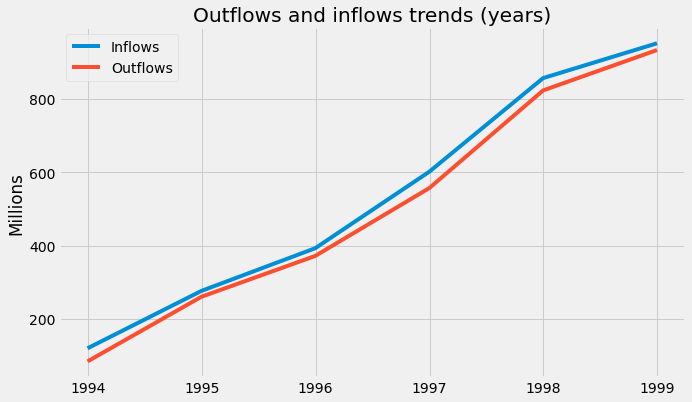

In [68]:
#Outflows and inflows trends - years aggregation
inflows = trans_bal_df['pos_sum'].resample('A').sum ()
outflows = trans_bal_df['neg_sum'].resample('A').sum ()

plt.style.use('fivethirtyeight')
x = outflows.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = list (inflows / 1000000) 
y2 = list (outflows / 1000000)
ax.set_ylabel('Millions')
ax.plot(x, y1, label = 'Inflows')
ax.plot(x, y2, label = 'Outflows' )#, figsize = (8,8))
ax.set_title("Outflows and inflows trends (years)")
plt.legend (loc = 'best')
plt.show()

In [69]:
#verifying overall balance of inflows and outflows for the whole reported period
display (trans_bal_df['neg_sum'].sum ())
display (trans_bal_df['pos_sum'].sum ())

3030321135.799999

3200001735.0

In [70]:
#Outflows details investigation

trans_negflow_df = trans_df.copy ()

#column with amounts that stand for cash withdrawal 
trans_negflow_df = trans_negflow_df.assign (cw_sum = np.nan)

#column with amounts that stand for withdrawal from credit card 
trans_negflow_df = trans_negflow_df.assign (cwc_sum = np.nan)

#column with amounts that stand for remittance to another banks 
trans_negflow_df = trans_negflow_df.assign (rem_sum = np.nan)

#filling columns pos_sum and neg_sum based on operation type. pos_sum stands for inflows
trans_negflow_df.cw_sum = trans_negflow_df.amount.where (trans_negflow_df.operation == 'VYBER', trans_negflow_df.cw_sum )
trans_negflow_df.cwc_sum = trans_negflow_df.amount.where (trans_negflow_df.operation == 'VYBER KARTOU', trans_negflow_df.cwc_sum)
trans_negflow_df.rem_sum = trans_negflow_df.amount.where (trans_negflow_df.operation == 'PREVOD NA UCET', trans_negflow_df.rem_sum)

#trans_negflow_df [trans_negflow_df ['operation'] == 'PREVOD NA UCET'].head (n=5)


In [71]:
#setting date as index for further visualization
trans_negflow_df.set_index (trans_negflow_df ['date'], inplace = True)
trans_negflow_df.head (n=3)

trans_id  account_id       date    type operation  amount  \
date                                                                    
1993-01-01    695247        2378 1993-01-01  PRIJEM     VKLAD   700.0   
1993-01-01    171812         576 1993-01-01  PRIJEM     VKLAD   900.0   
1993-01-01    207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   

            balance k_symbol bank  account  tran_year  cw_sum  cwc_sum  \
date                                                                     
1993-01-01    700.0      NaN  NaN      NaN       1993     NaN      NaN   
1993-01-01    900.0      NaN  NaN      NaN       1993     NaN      NaN   
1993-01-01   1000.0      NaN  NaN      NaN       1993     NaN      NaN   

            rem_sum  
date                 
1993-01-01      NaN  
1993-01-01      NaN  
1993-01-01      NaN

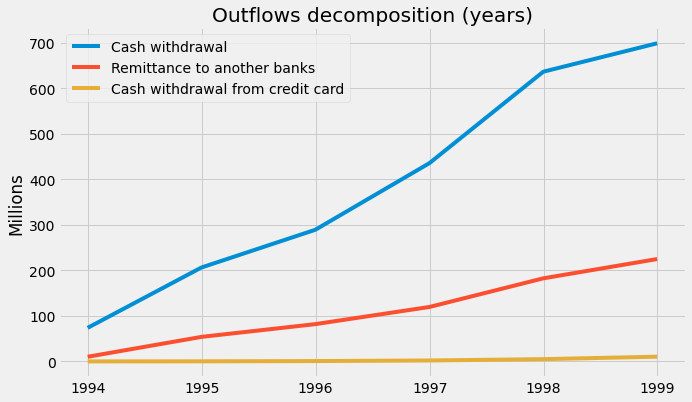

In [72]:
#plotting results outflows decomposition (years)
cashw = trans_negflow_df['cw_sum'].resample('A').sum ()
cashw_card = trans_negflow_df['cwc_sum'].resample('A').sum ()
remit = trans_negflow_df['rem_sum'].resample('A').sum ()

plt.style.use('fivethirtyeight')
x = cashw.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = list (cashw / 1000000) 
y2 = list (remit / 1000000)
y3 = list (cashw_card / 1000000)
ax.set_ylabel('Millions')
ax.plot(x, y1, label = 'Cash withdrawal')
ax.plot(x, y2, label = 'Remittance to another banks' )#, figsize = (8,8))
ax.plot(x, y3, label = 'Cash withdrawal from credit card' )#, figsize = (8,8))
ax.set_title("Outflows decomposition (years)")
plt.legend (loc = 'best')
plt.show()

### Question métier #3 (transactions) conclusion: 

- Répartition des types de transactions dans l'ensemble des données : traditionnellement, le retrait d'espèces est l'opération la plus populaire (41%), 19% pour les transferts de fonds d'une autre banque, 17% pour le crédit d'intérêt, le moins utilisé est le retrait d'espèces par carte de crédit.    
- La répartition des transactions au cours d'une période donnée (1993-1998) est pratiquement la même. Bien que le nombre d'opérations de transfert de fonds vers une autre banque soit plus important que le nombre d'encaissements auprès d'autres banques (certaines années, plus de deux fois), la somme globale sur une année est plus faible et le solde est positif. 
- Les flux entrants l'emportent sur les flux sortants au cours de la période considérée (année, mois), bien qu'il en aille différemment pour certains jours spécifiques.  


### Question métier #4 (Vision sur les prêts)

- Un prêt dont la mensualité est plus élevée a-t-il généralement tendance à être impayé ou en retard ?
- Est-ce qu'une durée plus longue d'un prêt est censée protéger contre les impayés dans la plupart des cas ?
- Existe-t-il une relation directe entre un montant de prêt plus élevé et une probabilité plus grande que le prêt soit en souffrance ?
- Répartition de l'état des prêts dans les districts. Existe-t-il des régions où l'exposition au crédit de la banque n'est pas dûment gérée ?  


In [73]:
loans2_df = loans_df.copy ()


In [74]:
#preparing dataset and replacing A, B, C, D with description text
loans2_df = loans_df.copy ()
loans2_df ['status_desc'] = loans2_df ['status']

dict1 =  {'A':'Contract finished, no problem', 
      'B':'Contract finised, loan was not paid',
      'C':'Runing contract, OK so far',
      'D':'Runing contract, client in debt'
     }
loans2_df.status_desc = loans2_df.status_desc.replace (dict1)

loans2_df ['status_numeric'] = loans2_df ['status']

#encoding bad loans as 1 and good ones as -1 
dict2 =  {'A':0, 
      'B':1,
      'C':0,
      'D':1
     }
loans2_df.status_numeric = loans2_df.status_numeric.replace (dict2)
display (loans2_df.head (n=3))

loan_id  account_id       date  amount  duration  payments status  \
0     5314        1787 1993-07-05   96396        12    8033.0      B   
1     5316        1801 1993-07-11  165960        36    4610.0      A   
2     6863        9188 1993-07-28  127080        60    2118.0      A   

                           status_desc  status_numeric  
0  Contract finised, loan was not paid               1  
1        Contract finished, no problem               0  
2        Contract finished, no problem               0

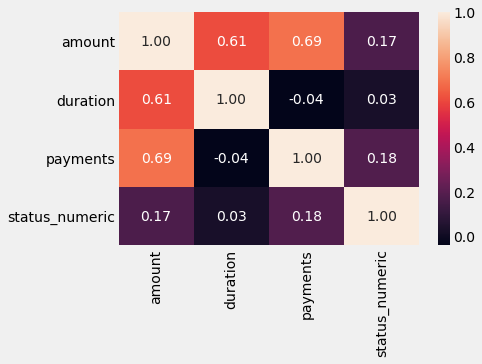

In [78]:
#correlation matrix
loans3_df = loans2_df.copy ()
loans3_df.drop (['loan_id', 'account_id'], axis =1, inplace = True)
sns.heatmap (loans3_df.corr (), annot = True, fmt=".2f");

In [79]:
# enriching dataframe with accounts_df 

loans_acc_df = loans2_df.copy ()
loans_acc_df = loans_acc_df.merge (accounts_df, left_on = 'account_id', right_on = 'account_id', 
                                           how = 'left') 
display (loans2_df.head (n=3))
display (loans_acc_df.head (n=3))

loan_id  account_id       date  amount  duration  payments status  \
0     5314        1787 1993-07-05   96396        12    8033.0      B   
1     5316        1801 1993-07-11  165960        36    4610.0      A   
2     6863        9188 1993-07-28  127080        60    2118.0      A   

                           status_desc  status_numeric  
0  Contract finised, loan was not paid               1  
1        Contract finished, no problem               0  
2        Contract finished, no problem               0

loan_id  account_id     date_x  amount  duration  payments status  \
0     5314        1787 1993-07-05   96396        12    8033.0      B   
1     5316        1801 1993-07-11  165960        36    4610.0      A   
2     6863        9188 1993-07-28  127080        60    2118.0      A   

                           status_desc  status_numeric  district_id  \
0  Contract finised, loan was not paid               1           30   
1        Contract finished, no problem               0           46   
2        Contract finished, no problem               0           45   

          frequency     date_y  
0    POPLATEK TYDNE 1993-03-22  
1  POPLATEK MESICNE 1993-02-13  
2  POPLATEK MESICNE 1993-02-08

In [80]:
# enriching dataframe with district_df data

loans_acc_distr_df = loans_acc_df.copy ()
loans_acc_distr_df = loans_acc_distr_df.merge (district_df, left_on = 'district_id', right_on = 'A1', 
                                           how = 'left') 
display (loans_acc_df.head (n=3))
display (loans_acc_distr_df.head (n=3))

loan_id  account_id     date_x  amount  duration  payments status  \
0     5314        1787 1993-07-05   96396        12    8033.0      B   
1     5316        1801 1993-07-11  165960        36    4610.0      A   
2     6863        9188 1993-07-28  127080        60    2118.0      A   

                           status_desc  status_numeric  district_id  \
0  Contract finised, loan was not paid               1           30   
1        Contract finished, no problem               0           46   
2        Contract finished, no problem               0           45   

          frequency     date_y  
0    POPLATEK TYDNE 1993-03-22  
1  POPLATEK MESICNE 1993-02-13  
2  POPLATEK MESICNE 1993-02-08

loan_id  account_id     date_x  amount  duration  payments status  \
0     5314        1787 1993-07-05   96396        12    8033.0      B   
1     5316        1801 1993-07-11  165960        36    4610.0      A   
2     6863        9188 1993-07-28  127080        60    2118.0      A   

                           status_desc  status_numeric  district_id  ...  A7  \
0  Contract finised, loan was not paid               1           30  ...   8   
1        Contract finished, no problem               0           46  ...   7   
2        Contract finished, no problem               0           45  ...   6   

  A8  A9   A10   A11   A12   A13  A14   A15   A16  
0  2  10  81.8  9650  3.38  3.67  100  2985  2804  
1  3  10  73.5  8369  1.79  2.31  117  2854  2618  
2  1   5  53.5  8390  2.28  2.89  132  2080  2122  

[3 rows x 28 columns]

In [81]:
#number of duplicated accounts in loans_acc_df. I was checking if several loans can be tied to the same account ? 
test_df = pd.DataFrame (loans_acc_df ['account_id'].duplicated ())
print (test_df [test_df ['account_id'] == True])

Empty DataFrame
Columns: [account_id]
Index: []


Un seul compte ne peut pas avoir plusieurs prêts


In [82]:
# enriching disposition dataframe with clients_df then I will have a df which will contain loan, district, 
#disposition and client info

dispos_client_df = dispos_df.copy ()
dispos_client_df = dispos_client_df.merge (clients_df, left_on = 'client_id', right_on = 'client_id', 
                                           how = 'left') 
display (dispos_df.head (n=3))
display (dispos_client_df.head (n=3))   

disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT

disp_id  client_id  account_id       type  birth_number  district_id  \
0        1          1           1      OWNER        706213           18   
1        2          2           2      OWNER        450204            1   
2        3          3           2  DISPONENT        406009            1   

  birth_date  gender  age  
0 1970-12-13     0.0   28  
1 1945-02-04     1.0   53  
2 1940-10-09     0.0   58

In [84]:
#number of duplicated accounts in dispos_client_df. checking if the same account can be tied to several clients
test2_df = pd.DataFrame (dispos_client_df ['account_id'].duplicated ())

print (dispos_client_df.shape) #number of disposition - clients 
print (test2_df [test2_df ['account_id'] == True].shape) #number of duplicates


(5369, 9)
(869, 1)


Cela signifie que les mêmes comptes peuvent être détenus par différents clients, l'un d'entre eux pouvant être propriétaire et le second disponent.

Impossible de fusionner loans_acc_distr_df enrichi avec certaines données relatives aux clients et de voir si certains facteurs personnels affectent le statut du prêt, car le même compte peut être détenu par différentes personnes.

In [85]:
#heatmap for correlation between districts and loan statuses
loans_acc_distr_df.head (n=3)

loan_id  account_id     date_x  amount  duration  payments status  \
0     5314        1787 1993-07-05   96396        12    8033.0      B   
1     5316        1801 1993-07-11  165960        36    4610.0      A   
2     6863        9188 1993-07-28  127080        60    2118.0      A   

                           status_desc  status_numeric  district_id  ...  A7  \
0  Contract finised, loan was not paid               1           30  ...   8   
1        Contract finished, no problem               0           46  ...   7   
2        Contract finished, no problem               0           45  ...   6   

  A8  A9   A10   A11   A12   A13  A14   A15   A16  
0  2  10  81.8  9650  3.38  3.67  100  2985  2804  
1  3  10  73.5  8369  1.79  2.31  117  2854  2618  
2  1   5  53.5  8390  2.28  2.89  132  2080  2122  

[3 rows x 28 columns]

In [86]:
## Using the pandas.groupby() method to produce a pivot table:

dist_loans_df = loans_acc_distr_df.groupby(by=['A2']).status_desc.value_counts().sort_index()
dist_loans_df.head (n=3)

A2       status_desc                  
Benesov  Contract finished, no problem    1
         Runing contract, OK so far       5
Beroun   Contract finished, no problem    1
Name: status_desc, dtype: int64

In [87]:
## Manipulating the data:
dist_loans_df = dist_loans_df.unstack()  #Converting the groupby object into a dataset
#dist_loans_df.head (n=10)
dist_loans_df.fillna(value=0.0, inplace=True)  #Replacing NaN values by zero
dist_loans_df = df_row_normalize(dist_loans_df)  #Normalizing its values by the total of each row
## Converting the normalized float values to percentual int values:
dist_loans_df = (dist_loans_df*100).astype(float).applymap('{:,.2f}'.format)#
dist_loans_df.head (n=5)

status_desc  Contract finised, loan was not paid  \
A2                                                 
Benesov                                     0.00   
Beroun                                      0.00   
Blansko                                     0.00   
Breclav                                    14.29   
Brno - mesto                                8.33   

status_desc  Contract finished, no problem Runing contract, OK so far  \
A2                                                                      
Benesov                              16.67                      83.33   
Beroun                               16.67                      50.00   
Blansko                              42.86                      42.86   
Breclav                              14.29                      71.43   
Brno - mesto                         16.67                      62.50   

status_desc  Runing contract, client in debt  
A2                                            
Benesov                                 0.00  
Beroun                                 33.33  
Blansko                                14.29  
Breclav                                 0.00  
Brno - mesto                           12.50

In [88]:
#converting df columns dtype into float16 so to make it visible in the heatmap. 
dist_loans_df = dist_loans_df.astype(np.float16)
dist_loans_df.dtypes

status_desc
Contract finised, loan was not paid    float16
Contract finished, no problem          float16
Runing contract, OK so far             float16
Runing contract, client in debt        float16
dtype: object

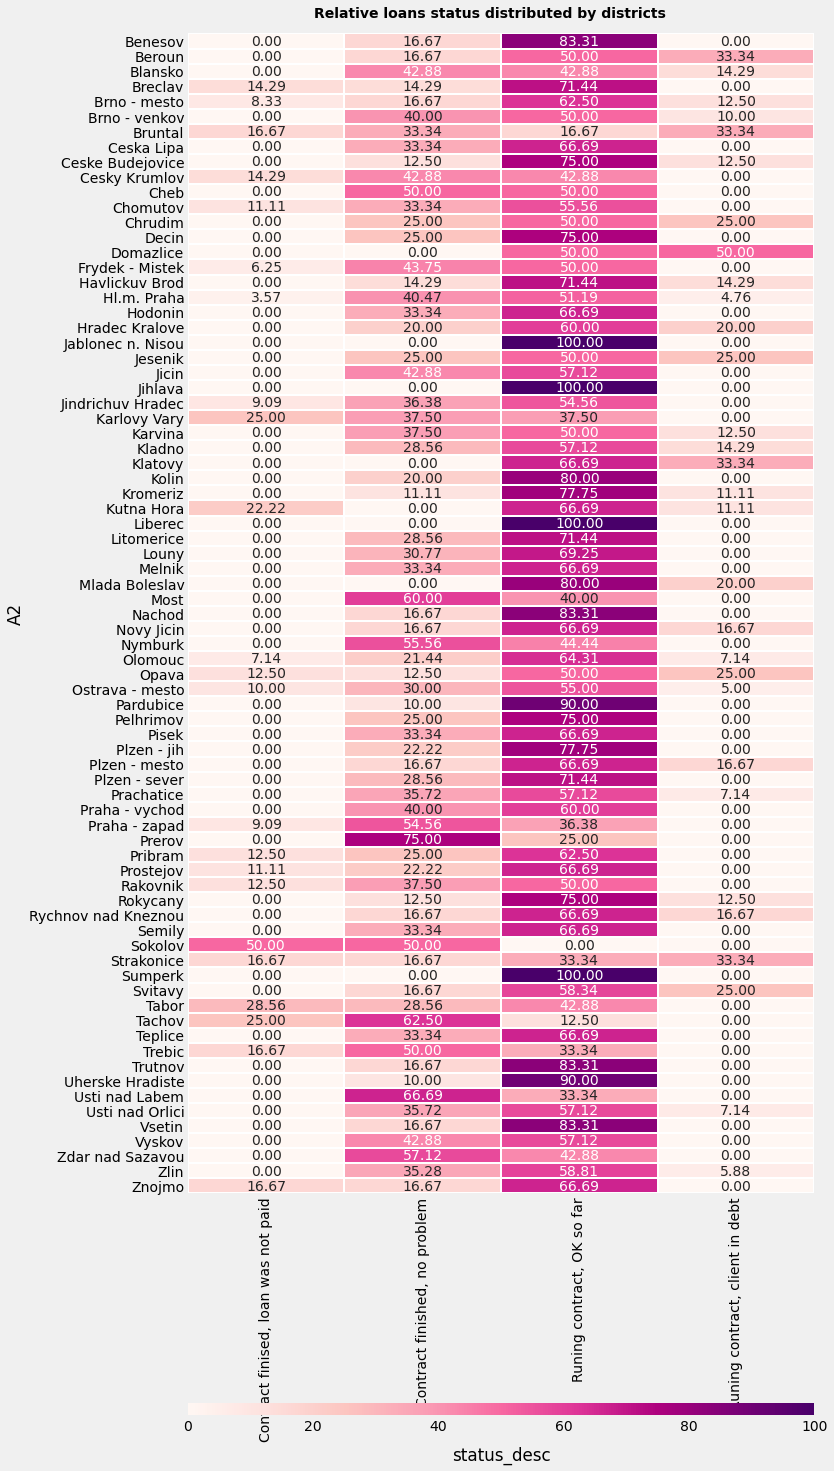

In [89]:
# Drawing a heatmap with the numeric values in each cell
fig3, ax = plt.subplots(figsize=(10, 25))
fig3.subplots_adjust(top=.965)
plt.suptitle('Relative loans status distributed by districts', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"horizontal", 'pad':0.13, 'aspect':50}
sns.heatmap(dist_loans_df, annot=True, fmt='.2f', linewidths=.3, cmap='RdPu', ax=ax, cbar_kws=cbar_kws );

### Question métier #4 (Vision sur les prêts) conclusion:

- En général, les paiements mensuels plus élevés sont liés aux prêts impayés ou en retard. 
- La matrice de corrélation nous permet de conclure qu'il y a une faible relation linéaire entre la durée du crédit et son statut. 
- Nous pouvons voir qu'un montant plus élevé de paiement mensuel est lié à des dettes impayées.   
- Strakonice, Sokolov, Opava, Kutna Hora, Klatovy, Domazlice, Bruntal, Beroun. Dans ces régions, le nombre de dettes problématiques est supérieur à 30%.** 


## Modélisation

### Feature engineering

Pour la partie feature enginering, nous allons prendre le dataset "**loans_acc_distr_df**" étudié dans la partie exploration. Par la suite, nous allons l'enrichir, en rajoutant des informations suivantes: 
- Données clients
- Aggregations sur les données de transactions

In [90]:
# distribution of target variable
loans_acc_distr_df.status_numeric.value_counts()/loans_acc_distr_df.shape[0]

0    0.888563
1    0.111437
Name: status_numeric, dtype: float64

**Rajout des informations lié au détenteur du compte bancaire:**

In [91]:
# add owners informations
df = loans_acc_distr_df\
    .merge(dispos_df[dispos_df.type=="OWNER"][["client_id","account_id"]], on="account_id", how="left")\
    .merge(clients_df[["client_id","gender","age"]], on="client_id", how="left")

**Rajout des informations lié aux transactions:**

In [92]:
# calculate the number of transaction per account
nb_trans_df = trans_df[['account_id', 'trans_id']].groupby('account_id').count().reset_index().rename(columns={'trans_id': 'nb_trans'})

# calculate the amount of credit transactions per account
amount_pos_trans_df = trans_df[trans_df.operation.isin(["VKLAD", "PREVOD Z UCTU", "INTEREST_CREDIT"])]\
    [['account_id', 'amount']].groupby('account_id').sum().reset_index().rename(columns={'amount': 'amount_pos_trans'})

# calculate the amount of debit transactions per account
amount_neg_trans_df = trans_df[trans_df.operation.isin(["VYBER KARTOU", "PREVOD NA UCET", "VYBER"])]\
    [['account_id', 'amount']].groupby('account_id').sum().reset_index().rename(columns={'amount': 'amount_neg_trans'})


In [93]:
# add transaction information :
df = df\
    .merge(nb_trans_df, on="account_id", how="left")\
    .merge(amount_pos_trans_df, on="account_id", how="left")\
    .merge(amount_neg_trans_df, on="account_id", how="left")

**Séparation des variables (Predictor variables(numeric/categorical) / Target variable):**

In [94]:
# column to keep
keeps = ['amount', 'duration', 'payments',
         'frequency', 'nb_trans', 'amount_pos_trans', 'amount_neg_trans', 'age', 'gender',
         'A1', 'A4', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

#categorical columns
categorical = ['frequency']

# target variable
target_variable = 'status_numeric'

In [95]:
# update crime indicator
df['A15'] = df['A15'].replace('?', np.NaN).astype(float)
df['A15'] = df['A15'].fillna(df['A15'].mean())

# update unemployment indicator
df['A12'] = df['A12'].replace('?', np.NaN).astype(float)
df['A12'] = df['A12'].fillna(df['A12'].mean())

**One hot encoding des variables catégorielles:**

In [96]:
# one hot encoding for categorical column (frequency)
X = pd.get_dummies(df[keeps])

# set target variable
y = df['status_numeric']

**Préparation de la base d'entrainement:**

In [97]:
from sklearn.model_selection import train_test_split

# Stratified split of the train and test set with train-test ratio of 6:4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                            stratify=y, random_state=10)

### Preprocessing

Etape importante qui permettra de faciliter l'apprentissage. Et éviter que les variable ayant des valeurs absolues importantes ait un fort impact dans le résultat en sortie.

On va utiliser le scaler PowerTransformer afin de ramener les variables à une distribution gaussienne de moyenne 0 et d'écart type 1.

In [98]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\users\rochd\desktop\interview_soge\czech-banking-fin-analysis\venv\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning:

divide by zero encountered in log



### Model fitting

In [99]:
X.shape

(682, 19)

#### Regression logistique

Une première tentative d'apprentissage avec la fonction LogisticRegression de sklearn en gardant les paramètres par défauts.

In [100]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\users\rochd\desktop\interview_soge\czech-banking-fin-analysis\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Evaluation :

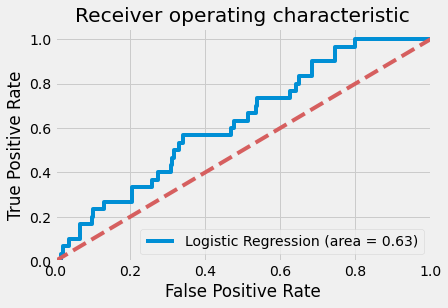

In [101]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Amélioration de la regression logistique

GridSearch permettra de trouver la combinaison de paramètres qui donneront le meilleure score

In [102]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), 
      "penalty":["l1","l2"],
      
      "class_weight":[
                      { 0:0.2, 1:0.8 },
                      { 0:0.25, 1:0.75 },
                      { 0:0.1 , 1:0.9  }
      ],
      "solver":['liblinear'],
     }

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=9, scoring = 'roc_auc', n_jobs=-1, iid=True)
logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("best auc :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'class_weight': {0: 0.25, 1: 0.75}, 'penalty': 'l1', 'solver': 'liblinear'}
best auc : 0.7364372751306975


c:\users\rochd\desktop\interview_soge\czech-banking-fin-analysis\venv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [103]:
logreg2=LogisticRegression(**logreg_cv.best_params_)
logreg2.fit(X_train,y_train)

LogisticRegression(C=100.0, class_weight={0: 0.25, 1: 0.75}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

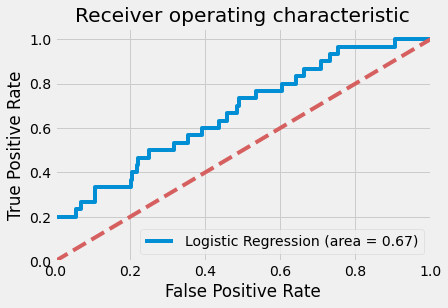

In [104]:
logit_roc_auc = roc_auc_score(y_test, logreg2.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Réseau de neuronnes

In [154]:
from keras.models import Sequential
from keras.layers import Dense, Normalization
from keras.metrics import AUC
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from keras import initializers, callbacks


# create model
model = Sequential()

#hidden layers
model.add(Dense(5, input_dim=19, activation='relu')) 
model.add(Dense(2,  activation='relu')) 

#output layer
model.add(Dense(1, activation='sigmoid'))

# Set early stopping if no improvement after 2 epochs
cb = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[{"auc":AUC()}])

history = model.fit(X_train, y_train, epochs=1000, batch_size=124, validation_data=(X_test, y_test), callbacks=cb)

Epoch 1/1000
4/4 [==============================] - 1s 127ms/step - loss: 0.6340 - auc_18: 0.4897 - val_loss: 0.6235 - val_auc_18: 0.5342
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.6253 - auc_18: 0.5077 - val_loss: 0.6176 - val_auc_18: 0.5303
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6209 - auc_18: 0.4682 - val_loss: 0.6118 - val_auc_18: 0.5439
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.6162 - auc_18: 0.4615 - val_loss: 0.6061 - val_auc_18: 0.5447
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6113 - auc_18: 0.4893 - val_loss: 0.6003 - val_auc_18: 0.5471
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6044 - auc_18: 0.4892 - val_loss: 0.5946 - val_auc_18: 0.5375

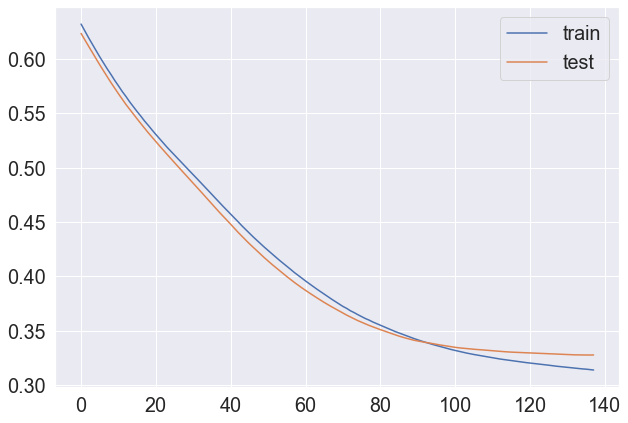

In [276]:
# plot training history
plt.figure(figsize = (9,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

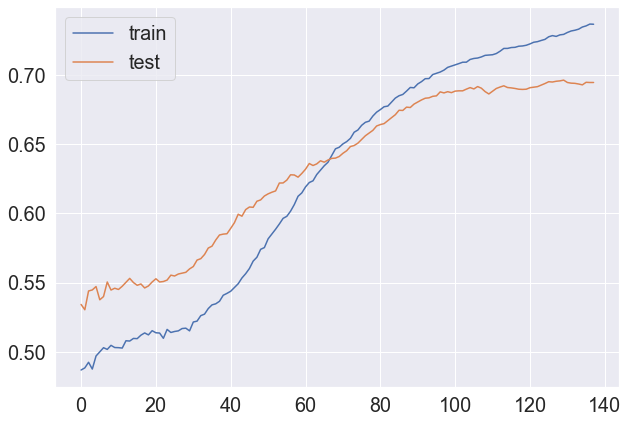

In [275]:
# plot training history
plt.figure(figsize = (9,7))
plt.plot(history.history['auc_18'], label='train')
plt.plot(history.history['val_auc_18'], label='test')
plt.legend()
plt.show()

Un early stopping a été utilisé afin d'anticiper un éventuel overfitting. 

Sur 2 epochs consécutive si on obsèrve pas d'amélioration au niveau de la fonction de coût calculé sur la base de test, on arrête l'apprentissage.

## Evaluation & Comparaison:

         fpr       tpr     1-fpr        tf  thresholds
29  0.320988  0.666667  0.679012 -0.012346    0.134184


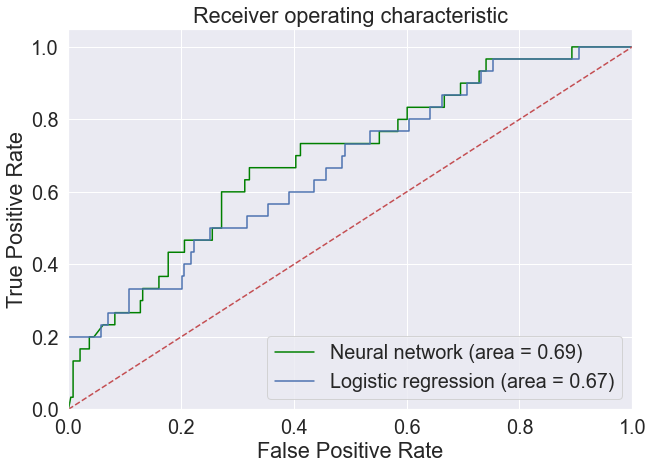

In [274]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
logit_roc_auc_log = roc_auc_score(y_test, logreg2.predict_proba(X_test)[:,1])

fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:,0])
fpr_log, tpr_log, _ = roc_curve(y_test, logreg2.predict_proba(X_test)[:,1])

plt.figure(figsize = (9,7))
plt.plot(fpr, tpr, label='Neural network (area = %0.2f)' % logit_roc_auc, color='green')
plt.plot(fpr_log, tpr_log, label='Logistic regression (area = %0.2f)' % logit_roc_auc_log)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################


i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
best_cut_off = roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
print(roc.iloc[(roc.tf-0).abs().argsort()[:1]])

En rajoutant un peu de complexité avec un réseau de neuronnes par rapport au modèle qui se base sur la regression logistique nous constatons une amélioration au niveau du score AUC.

Avec cela, nous sommes proches de la zone [0.7, 0.8] où on a une classification acceptable.


              precision    recall  f1-score   support

           0       0.94      0.68      0.79       243
           1       0.20      0.63      0.30        30

    accuracy                           0.67       273
   macro avg       0.57      0.66      0.54       273
weighted avg       0.86      0.67      0.73       273



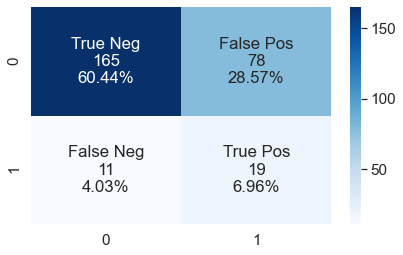

In [273]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

predictions = (model.predict(X_test)[:,0]>best_cut_off)*1
cf_matrix = confusion_matrix(y_test, predictions)


group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
sns.set(font_scale=1.8)
print(classification_report(y_test, predictions))

## Conclusion & Ouverture


En se basant sur les résultats du réseau de neurones, nous sommes sur une couverture de 63% et une précision de 20% par rapport à la prédiction d'un défaut de crédit.

En effet, sur les vrais "défaut de crédit" on detecte: 63%, et sur les prédictions du modèle en "défaut de crédit": 20% sont vrais.

Le modèle est à une précision et couverture respectivement de 94% et 68% sur les "Prêts sûrs". C'est à dire, sur les prédictions d'un "prêt sûr "94% sont effectivement des "prêts sûrs" n'ayant pas fait de défaut : On peut dire que le modèle cible bien la classe des "prêts sûrs". Sur la couverture, on constate 32% de cas qui ont été considéré à tort comme "prêt à risque" avec une probabilité de défaut élevée. En augmentant le seuil de prédiction, il est possible de réduire les 32%, néanmoins, cela va être au détriment de la classe "défaut de crédit".

Si le besoin métier a comme priorité de sécuriser l'attribution d'un prêt et donc couvrir le plus de cas de "défaut de crédit" possible -sans se soucier forcément du nombre de personnes qui peuvent rembourser leur prêt et qui ont été classifié à risque-, ce modèle couvrira 63% des "défaut de crédit" potentiel.


**Piste à explorer**

Afin d'augmenter la pertinence & la couverture, il est possible de :
- Attribuer plus de temps à la partie feature engineering en rajoutant plus d'indicateur pour le modèle d'apprentissage.
    - Exploration de la table orders.csv & exploitation de cette dernière afin de rajouter plus d'information à l'apprentissage.
    - Définir des indicateurs en collaboration avec des experts métiers.
- Dans le cadre d'une problématique similaire à **Société Générale**, il est possible d'avoir un échantillon plus conséquent en termes de volume de données et par la suite tenter de faire un apprentissage plus avancé afin d'arriver à un AUC excellent > 0.8 .
- Résoudre le problème des données non équilibrées (sur-représentation de la classe "Prêt sûr")
- Définir un seuil de patience plus élevé pour le early stopping: donner une chance au gradient de poursuivre la descente sur plus de 2 epochs sans amélioration en termes de la fonction de coût.
- Adopter un modèle Hybride en se basant à la fois sur des règles métiers et sur un modèle de Machine Learning.


## Références


- MACHINE LEARNING IN CREDIT RISK: MEASURING THE DILEMMA BETWEEN PREDICTION AND SUPERVISORY COST, Banco de Espana https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3724374
- https://medium.com/@t.kussainov/moving-from-gut-feeling-to-data-driven-decisions-in-a-bank-with-limited-budget-aa9f33f7886c
- https://github.com/Kusainov/czech-banking-fin-analysis
